# Ptch1 and body location

In [1]:
import scanpy as sc
import numpy as np
import scanpy.external as sce
import pandas as pd
import scvelo as scv
import seaborn as sns
import matplotlib.pyplot as plt
import importlib
import sys
import symphonypy as sp
import scFates as scf

import sys
sys.path.append("/home/sergey/tools/scLiTr/")
import sclitr as sl

import matplotlib

matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42

# Figures aesthetics
sc.set_figure_params(dpi=150)
sns.set_style("ticks")

In [2]:
sc.settings.figdir = "Ptch1_body_location/"

In [3]:
def pval_to_star(pval, GSEA_threshold=False):
    """
    This function returns star-formatted p-value.
    
    Parameters
    ----------
    pval : float
        P-value
        
    Returns
    ----------
    Star-formatted p-value.
    """
    if pval < 0.0001:
        return "****"
    elif pval < 0.001:
        return "***"
    elif pval < 0.01:
        return "**"
    elif pval < 0.05:
        return "*"
    elif pval < 0.25 and GSEA_threshold:
        return "."
    else:
        return " "

In [4]:
adata = sc.read_h5ad("/home/sergey/data/clonal_project/anndatas/perturbations_noEtOH/clone2vec/trunk_mesenchyme_merged.h5ad")
clones = sc.read_h5ad("/home/sergey/data/clonal_project/anndatas/perturbations_noEtOH/clone2vec/trunk_clone2vec.h5ad")

In [5]:
clones7 = clones[clones.obs_names.str.startswith("E7.5")].copy()
clones7.obs.index = [bc[5:] for bc in clones7.obs_names]

clones8 = clones[clones.obs_names.str.startswith("E8.5")].copy()
clones8.obs.index = [bc[5:] for bc in clones8.obs_names]

clones7_expr = sl.tl.summarize_expression(
    adata=adata,
    clones=clones7,
    obs_name="E7.5:clones",
)

clones8_expr = sl.tl.summarize_expression(
    adata=adata,
    clones=clones8,
    obs_name="E8.5:clones",
)

clones7_expr.obs.index = "E7.5:" + clones7_expr.obs.index
clones8_expr.obs.index = "E8.5:" + clones8_expr.obs.index

clones_expr = clones7_expr.concatenate(
    clones8_expr,
    join="outer",
    batch_key=None,
    index_unique=None,
    fill_value=0,
)

In [6]:
genes = np.array([
    "Hoxc13", "Hoxc12", "Hoxc11",
    "Hoxd11", "Hoxc10", "Hoxd9",
    "Hoxc8", "Hoxa7", "Hoxc6", "Hoxb5",
    "Hoxb4"
])

anterio_posterior_signature = dict(enumerate(genes[::-1]))
anterio_posterior_signature = dict(zip(anterio_posterior_signature.values(), [i + 1 for i in anterio_posterior_signature.keys()]))

clones_expr.obs["Hox_position"] = (
    clones_expr[:, list(anterio_posterior_signature.keys())].X *
    np.array(list(anterio_posterior_signature.values())) / 
    clones_expr[:, list(anterio_posterior_signature.keys())].X.sum(axis=1).T.A
)[0]

clones_expr.obs["Hox_position"] = (
    clones_expr.obs["Hox_position"] - clones_expr.obs["Hox_position"].min()
) / (clones_expr.obs["Hox_position"].max() - clones_expr.obs["Hox_position"].min())

clones_expr.obs["Hox_position"] = [i if str(i) != "nan" else 0.5 for i in clones_expr.obs["Hox_position"]]
clones.obs["Hox_position"] = clones_expr[clones.obs_names].obs["Hox_position"].copy()

In [7]:
clones_mesenchyme = clones[clones.obs["leiden_0.5"].isin(
    ["1", "2", "3", "4", "5", "6", "8"]
)].copy()

sc.pp.neighbors(clones_mesenchyme, n_neighbors=15, use_rep="word2vec")
sc.tl.umap(clones_mesenchyme, min_dist=0.3)

2025-04-08 01:42:54.431257: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-08 01:42:54.520236: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-08 01:42:54.543790: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-08 01:42:54.703725: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-08 01:42:56.064740: W tensorflow/compiler/tf2

In [8]:
perturbation_colors = {
    "Acvr2a": "#a1b8d4",
    "Acvrl1": "#e68483",
    "Bmpr1a": "#8cc177",
    "Bmpr2": "#73473e",
    "EGFP-1": "#bb2727",
    "EtOH": "#238a56",
    "Fgfr1": "#266296",
    "Fzd2": "#2eaeb7",
    "Fzd4": "#6e4a87",
    "Hhip": "#b08a7f",
    "Lgr4": "#d1d37d",
    "Lrp2": "#b59fc0",
    "Lrp4": "#93cfd3",
    "Ptch1": "#f2ad6a",
    "Tgfbr3": "#eaa8bf",
    "multi_gRNA": "#e26b26",
    "uncertain": "#a4ad55",
    "NA": "#cccccc",
    "multiple": "#cccccc",
}

clones_mesenchyme.uns["perturbation_colors"] = [
    perturbation_colors[gRNA] for gRNA in clones_mesenchyme.obs.perturbation.cat.categories
]

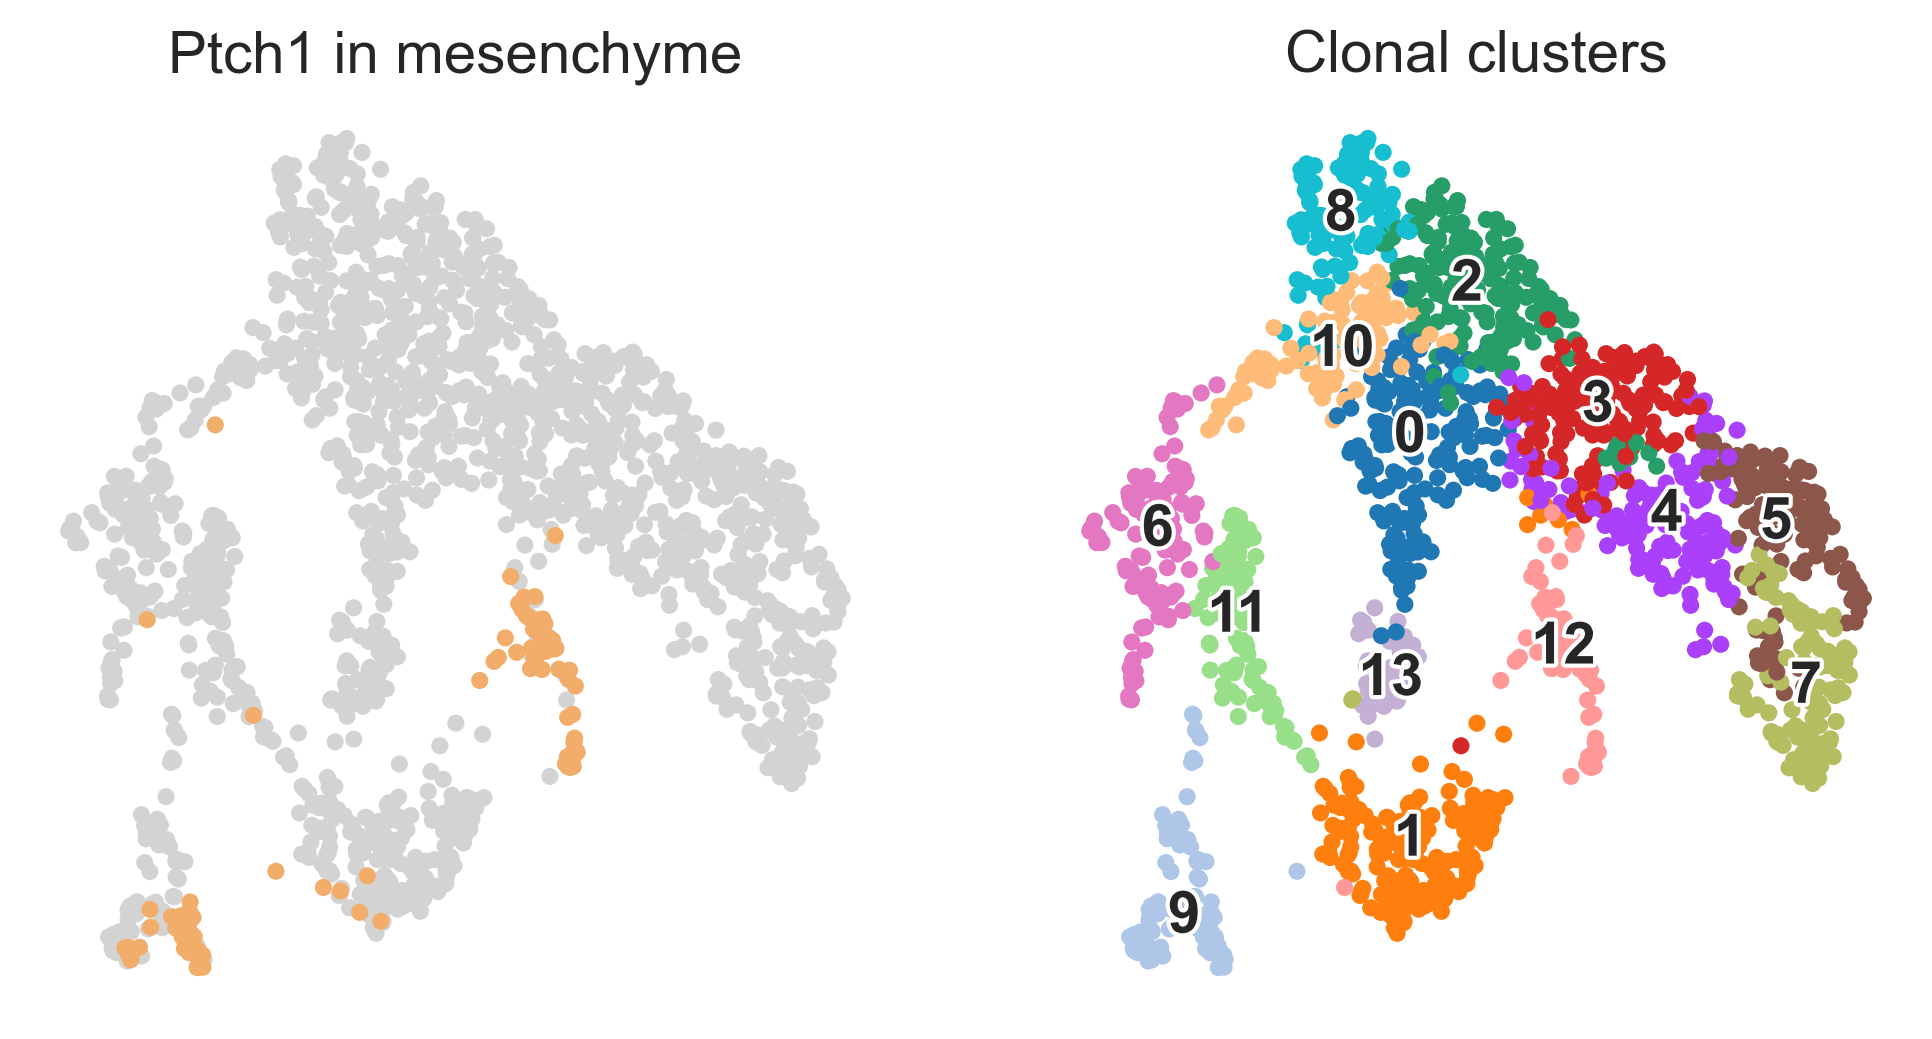

In [9]:
sc.tl.leiden(clones_mesenchyme, resolution=1)

fig, axes = plt.subplots(ncols=2, figsize=(8, 4))

sc.pl.umap(clones_mesenchyme, color="perturbation", groups=["Ptch1"],
           na_in_legend=False, frameon=False, legend_loc=None,
           title="Ptch1 in mesenchyme", ax=axes[0], show=False)

sc.pl.umap(clones_mesenchyme, color="leiden", na_in_legend=False, frameon=False, 
           title="Clonal clusters", ax=axes[1], show=False, legend_loc="on data",
           legend_fontoutline=2)

plt.savefig("Ptch1_body_location/UMAPs_clones_mesenchyme.pdf", bbox_inches="tight")

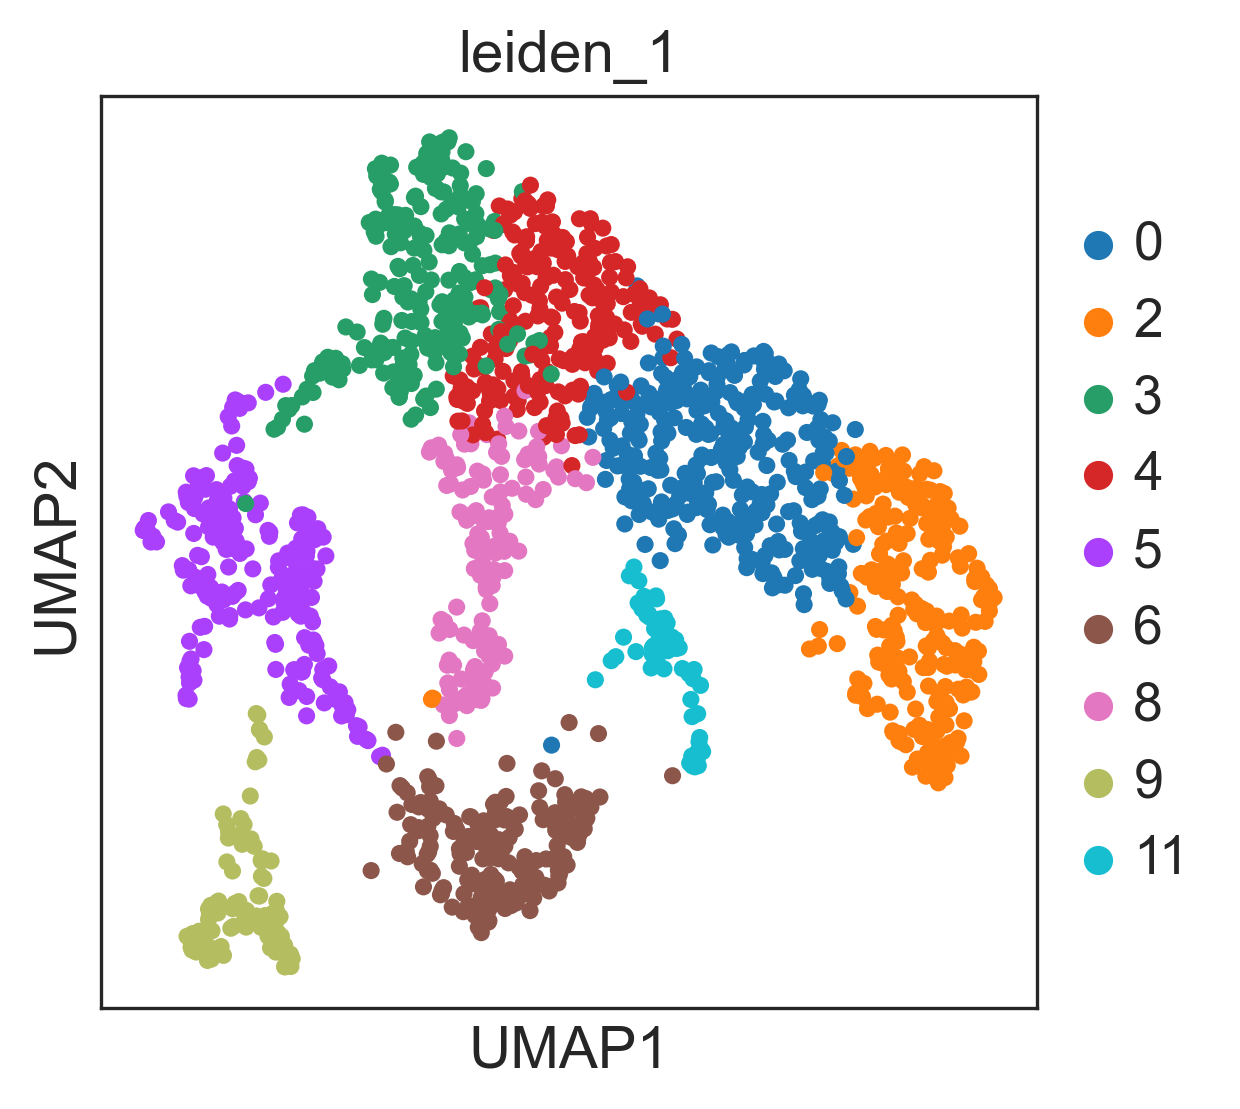

In [18]:
sc.pl.umap(clones_mesenchyme, color="leiden_1")

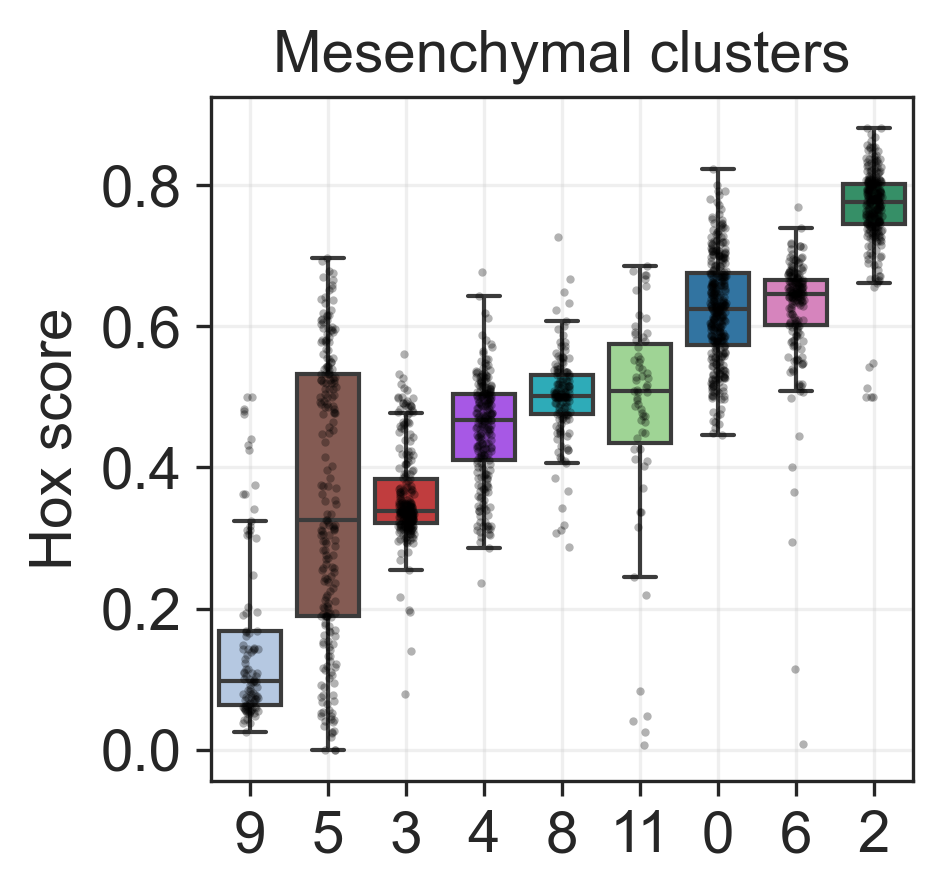

In [22]:
fig, ax = plt.subplots(figsize=(3, 3))

sns.boxplot(
    x="leiden_1",
    y="Hox_position",
    data=clones_mesenchyme.obs,
    ax=ax,
    showfliers=False,
    palette=dict(zip(
        clones.obs.leiden_1.cat.categories,
        clones.uns["leiden_1_colors"],
    )),
    order=clones_mesenchyme.obs.Hox_position.groupby(
        clones_mesenchyme.obs.leiden_1
    ).median().sort_values().index,
)

sns.stripplot(
    x="leiden_1",
    y="Hox_position",
    data=clones_mesenchyme.obs,
    ax=ax,
    color="k",
    order=clones_mesenchyme.obs.Hox_position.groupby(
        clones_mesenchyme.obs.leiden_1
    ).median().sort_values().index,
    s=2,
    alpha=0.3,
)

ax.set_xlabel("")
ax.set_ylabel("Hox score")
ax.grid(alpha=0.3)
ax.set_title("Mesenchymal clusters")

plt.savefig("Ptch1_body_location/boxplot_hox_score_old.pdf", bbox_inches="tight")

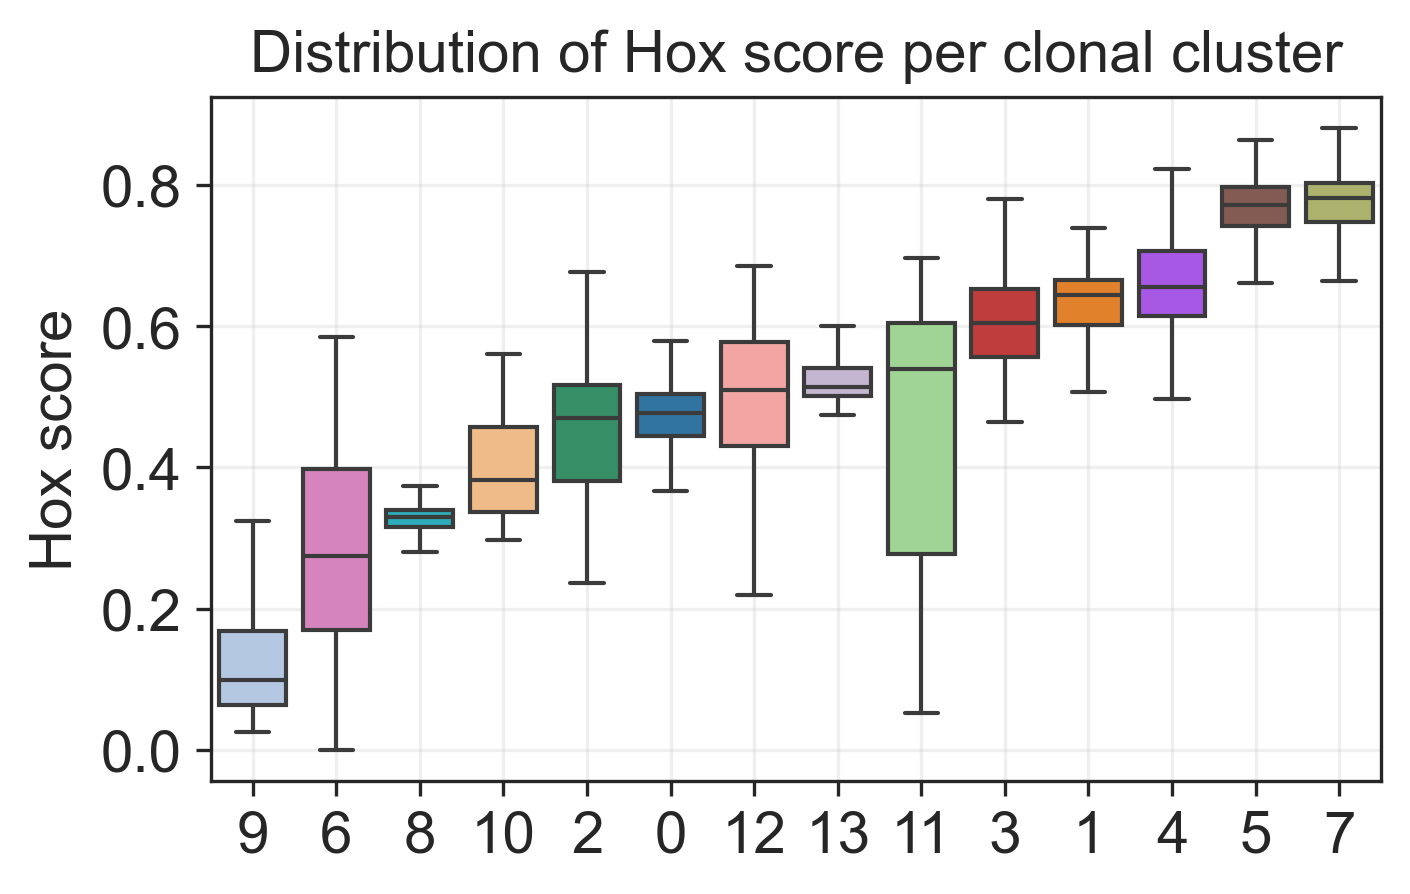

In [26]:
fig, ax = plt.subplots(figsize=(5, 3))

sns.boxplot(
    x="leiden",
    y="Hox_position",
    data=clones_mesenchyme.obs,
    ax=ax,
    showfliers=False,
    palette=dict(zip(
        clones_mesenchyme.obs.leiden.cat.categories,
        clones_mesenchyme.uns["leiden_colors"],
    )),
    order=clones_mesenchyme.obs.groupby(
        ["leiden"]
    ).median()["Hox_position"].sort_values().index,
)

ax.set_xlabel("")
ax.set_ylabel("Hox score")
ax.grid(alpha=0.3)
ax.set_title("Distribution of Hox score per clonal cluster")

plt.savefig("Ptch1_body_location/boxplot_hox_score.pdf", bbox_inches="tight")

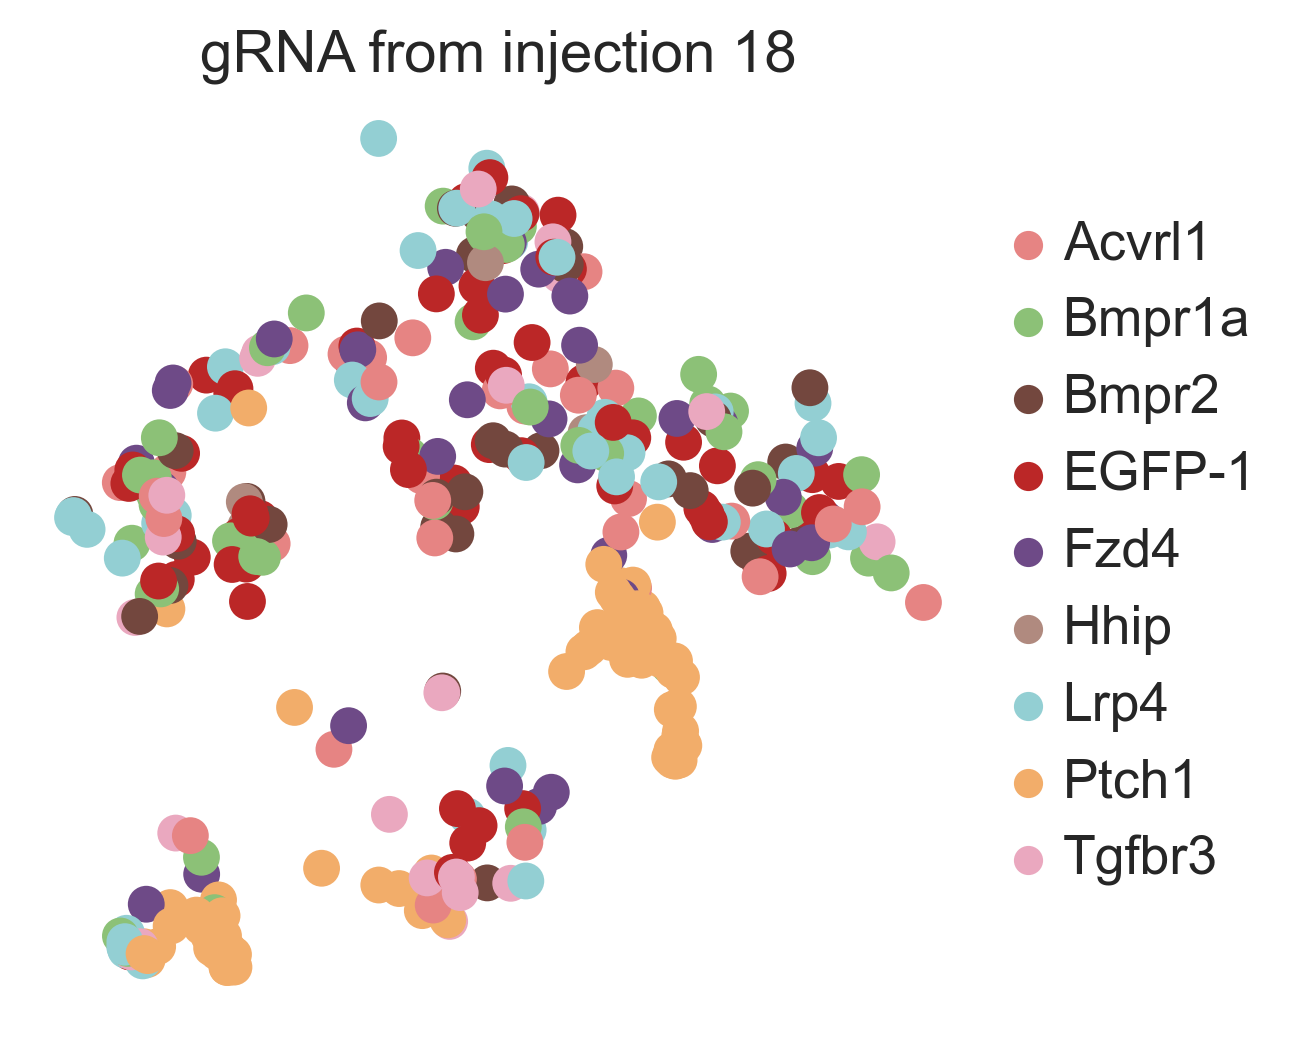

In [23]:
clones_mes_gRNA = clones_mesenchyme[~clones_mesenchyme.obs.perturbation.isin(["NA", "uncertain", "multi_gRNA"])].copy()
clones_mes_gRNA = clones_mes_gRNA[["injection18" in bc for bc in clones_mes_gRNA.obs_names]].copy()

sc.pl.umap(clones_mes_gRNA, color="perturbation", frameon=False, title="gRNA from injection 18",
           save="_injection18.pdf")

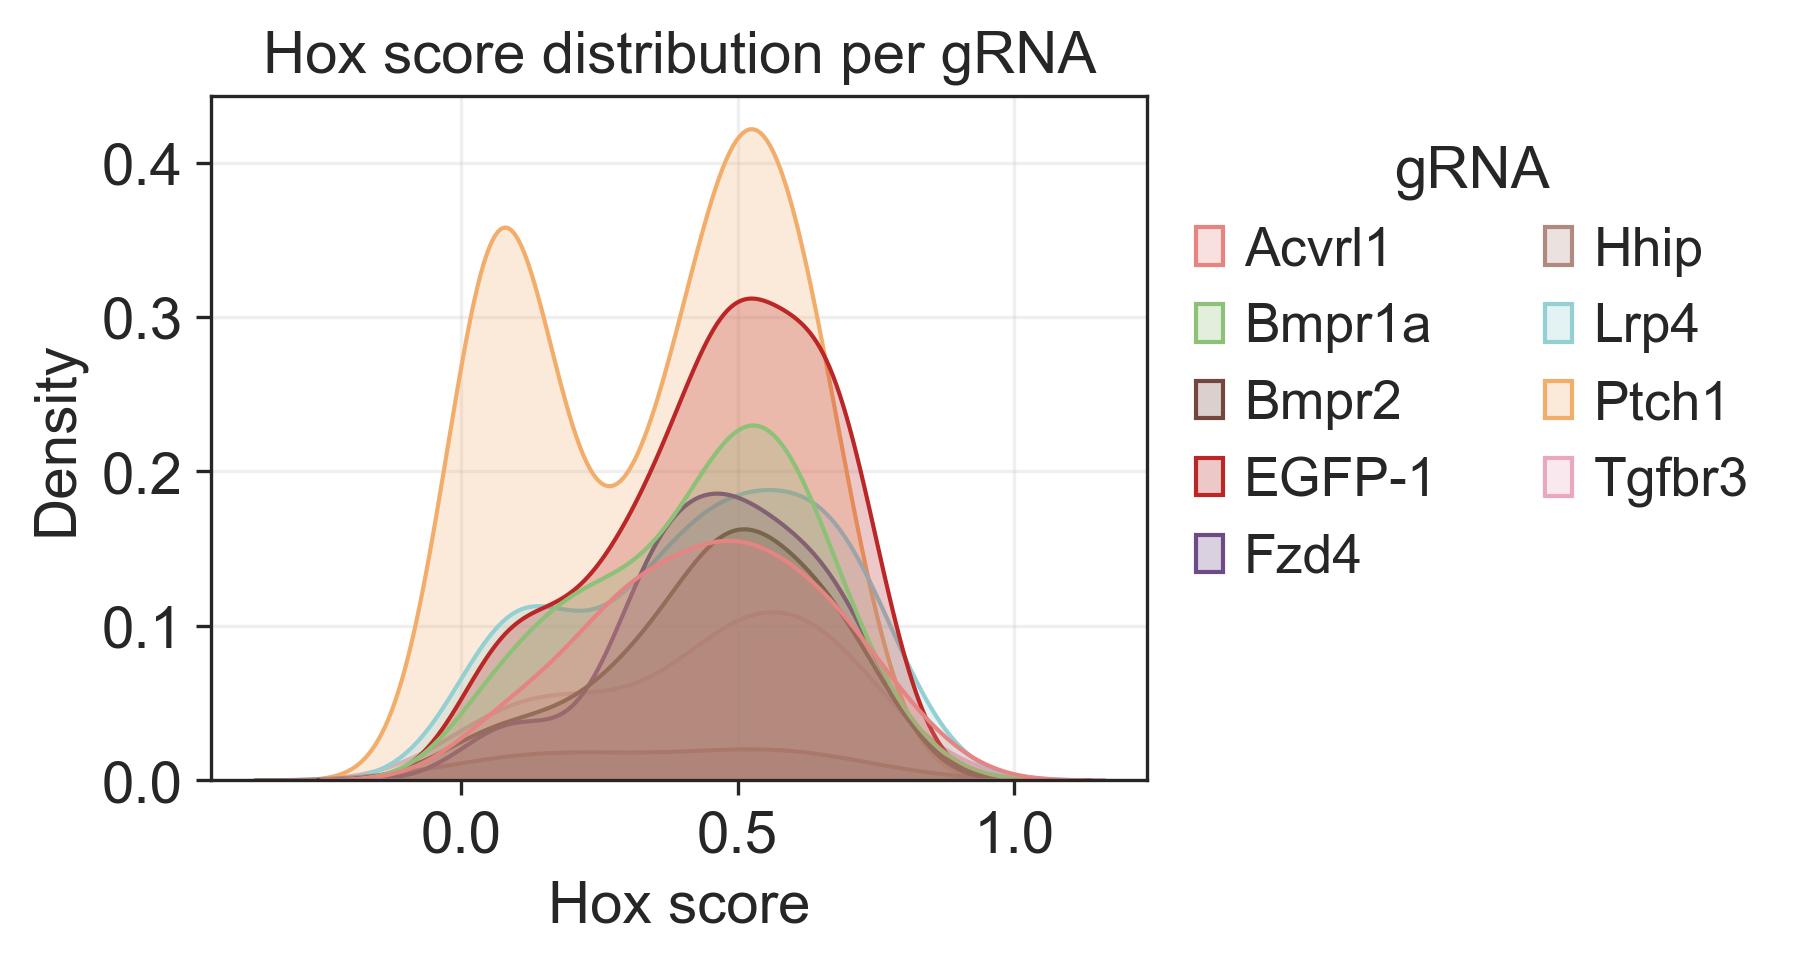

In [28]:
fig, ax = plt.subplots(figsize=(4, 3))

sns.kdeplot(
    x=clones_mes_gRNA.obs.Hox_position,
    hue=clones_mes_gRNA.obs.perturbation,
    ax=ax,
    legend=True,
    fill=True,
    palette=dict(zip(
        clones_mes_gRNA.obs.perturbation.cat.categories,
        clones_mes_gRNA.uns["perturbation_colors"],
    )),
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1),
                title="gRNA", edgecolor="white", ncols=2)
ax.grid(alpha=0.3)

ax.set_title("Hox score distribution per gRNA")
ax.set_xlabel("Hox score")

plt.savefig("Ptch1_body_location/hox_score_distribution.pdf", bbox_inches="tight")

In [14]:
from scipy.stats import ks_2samp

ks_stats = {}
ks_ps = {}

for pert1 in clones_mes_gRNA.obs.perturbation.cat.categories:
    ks_stats[pert1] = {}
    ks_ps[pert1] = {}
    for pert2 in clones_mes_gRNA.obs.perturbation.cat.categories:
        ks_stats[pert1][pert2] = ks_2samp(
            data1=clones_mes_gRNA.obs.Hox_position[clones_mes_gRNA.obs.perturbation == pert1],
            data2=clones_mes_gRNA.obs.Hox_position[clones_mes_gRNA.obs.perturbation == pert2],
        ).statistic
        ks_ps[pert1][pert2] = ks_2samp(
            data1=clones_mes_gRNA.obs.Hox_position[clones_mes_gRNA.obs.perturbation == pert1],
            data2=clones_mes_gRNA.obs.Hox_position[clones_mes_gRNA.obs.perturbation == pert2],
        ).pvalue
        
ks_stats = pd.DataFrame(ks_stats)
ks_ps = pd.DataFrame(ks_ps)
for genotype in ks_ps.columns:
    ks_ps[genotype] = ks_ps[genotype].apply(pval_to_star)

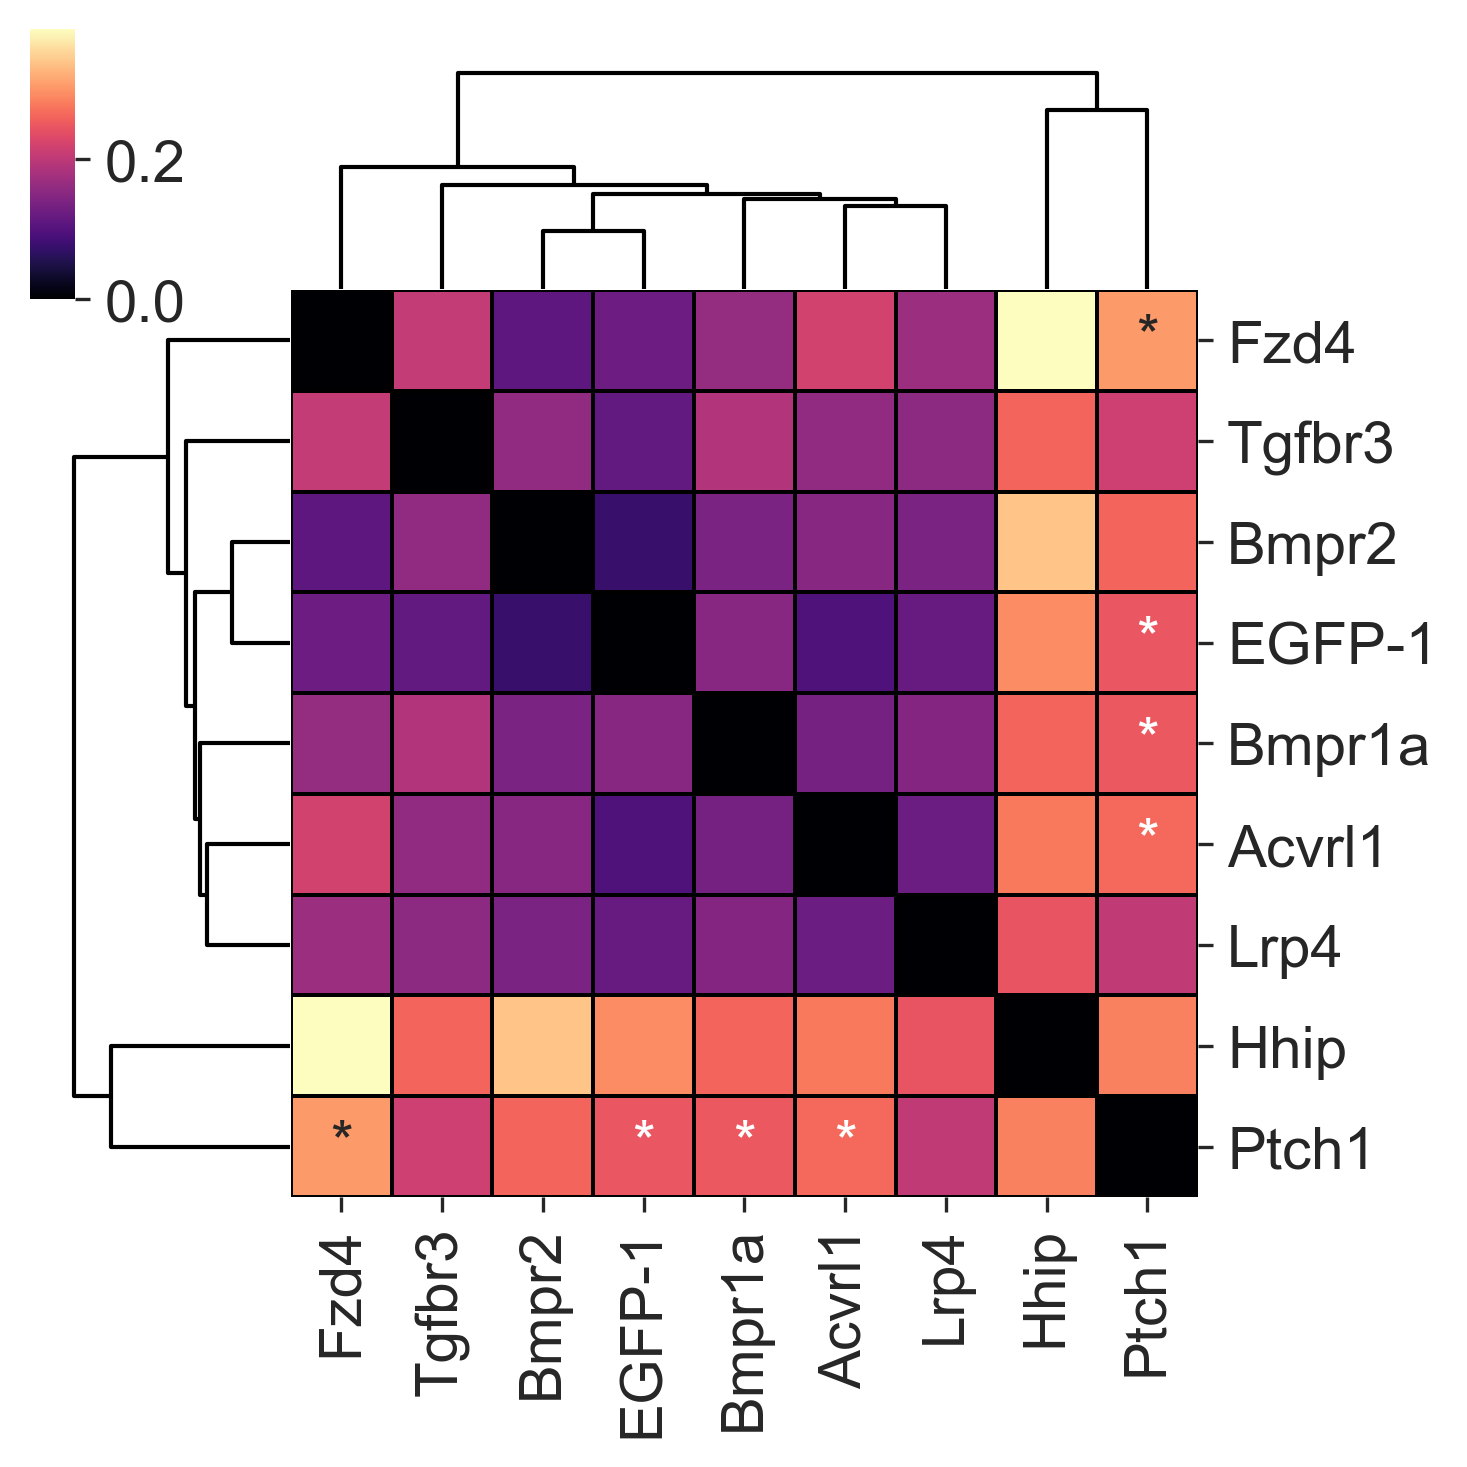

In [15]:
sns.clustermap(
    ks_stats,
    figsize=(5, 5),
    linecolor="black",
    linewidth=0.5,
    cbar_pos=(0.02, 0.8, 0.03, 0.18),
    tree_kws={"linewidth": 1, "color": "black"},
    annot=ks_ps,
    fmt="",
    cmap="magma",
)

plt.savefig("Ptch1_body_location/clustermap_distribution_distance.pdf", bbox_inches="tight")

In [366]:
min_cells = 200
selected_cts = clones_mesenchyme.var_names[clones_mesenchyme.X.sum(axis=0) > min_cells]
clones_corr = clones_mesenchyme[:, selected_cts].copy()
clones_corr.X = clones_corr.layers["frequencies"]

In [931]:
ct_order = np.array([
    'Kidney', 'Epicardium', 'Endothelial cells', 'Duct mesenchyme',
    'Cardiac fibroblasts', 'Visceral mesenchyme', 'VSMC',
    'Epithelial cells', 'Middle mesenchyme', 'Mesenchyme', 'Dermal mesenchyme',
    'Connective mesenchyme', 'Preskeletal chondro IVD', 'IVD', 'Tenocytes',
    'Preskeletal mesenchyme', 'Muscle', 'Osteoblasts', 'Chondroblasts',
    'Preskeletal osteo fibroblasts', 'Preskeletal osteo chondrocytes',
    'Pericytes', 'Meningeal fibroblasts', 'Dermal fibroblasts',
    'Dorsal progenitor medial', 'Dorsal inhibitory lateral',
    'Ventral neurons', 'CNS progenitor', 'Ventral progenitors',
    'Dorsal inhibitory', 'Dorsal excitatory', 'Dorsal excitatory lateral',
    'Ventral motor progenitor', 
    'Cardiac muscle', 'Sensory', 'Glia', 'Neuron autonomic', 'Chromaffin',
    'Autonomic bridge', 'Melanocytes', 'CNS', 'Autonomic HOXB',
    'Epithelial cells', 'Immune cells', 'Erythrocytes', 'Skin', 'Liver'
])

ct_order = ct_order[np.isin(ct_order, selected_cts)]

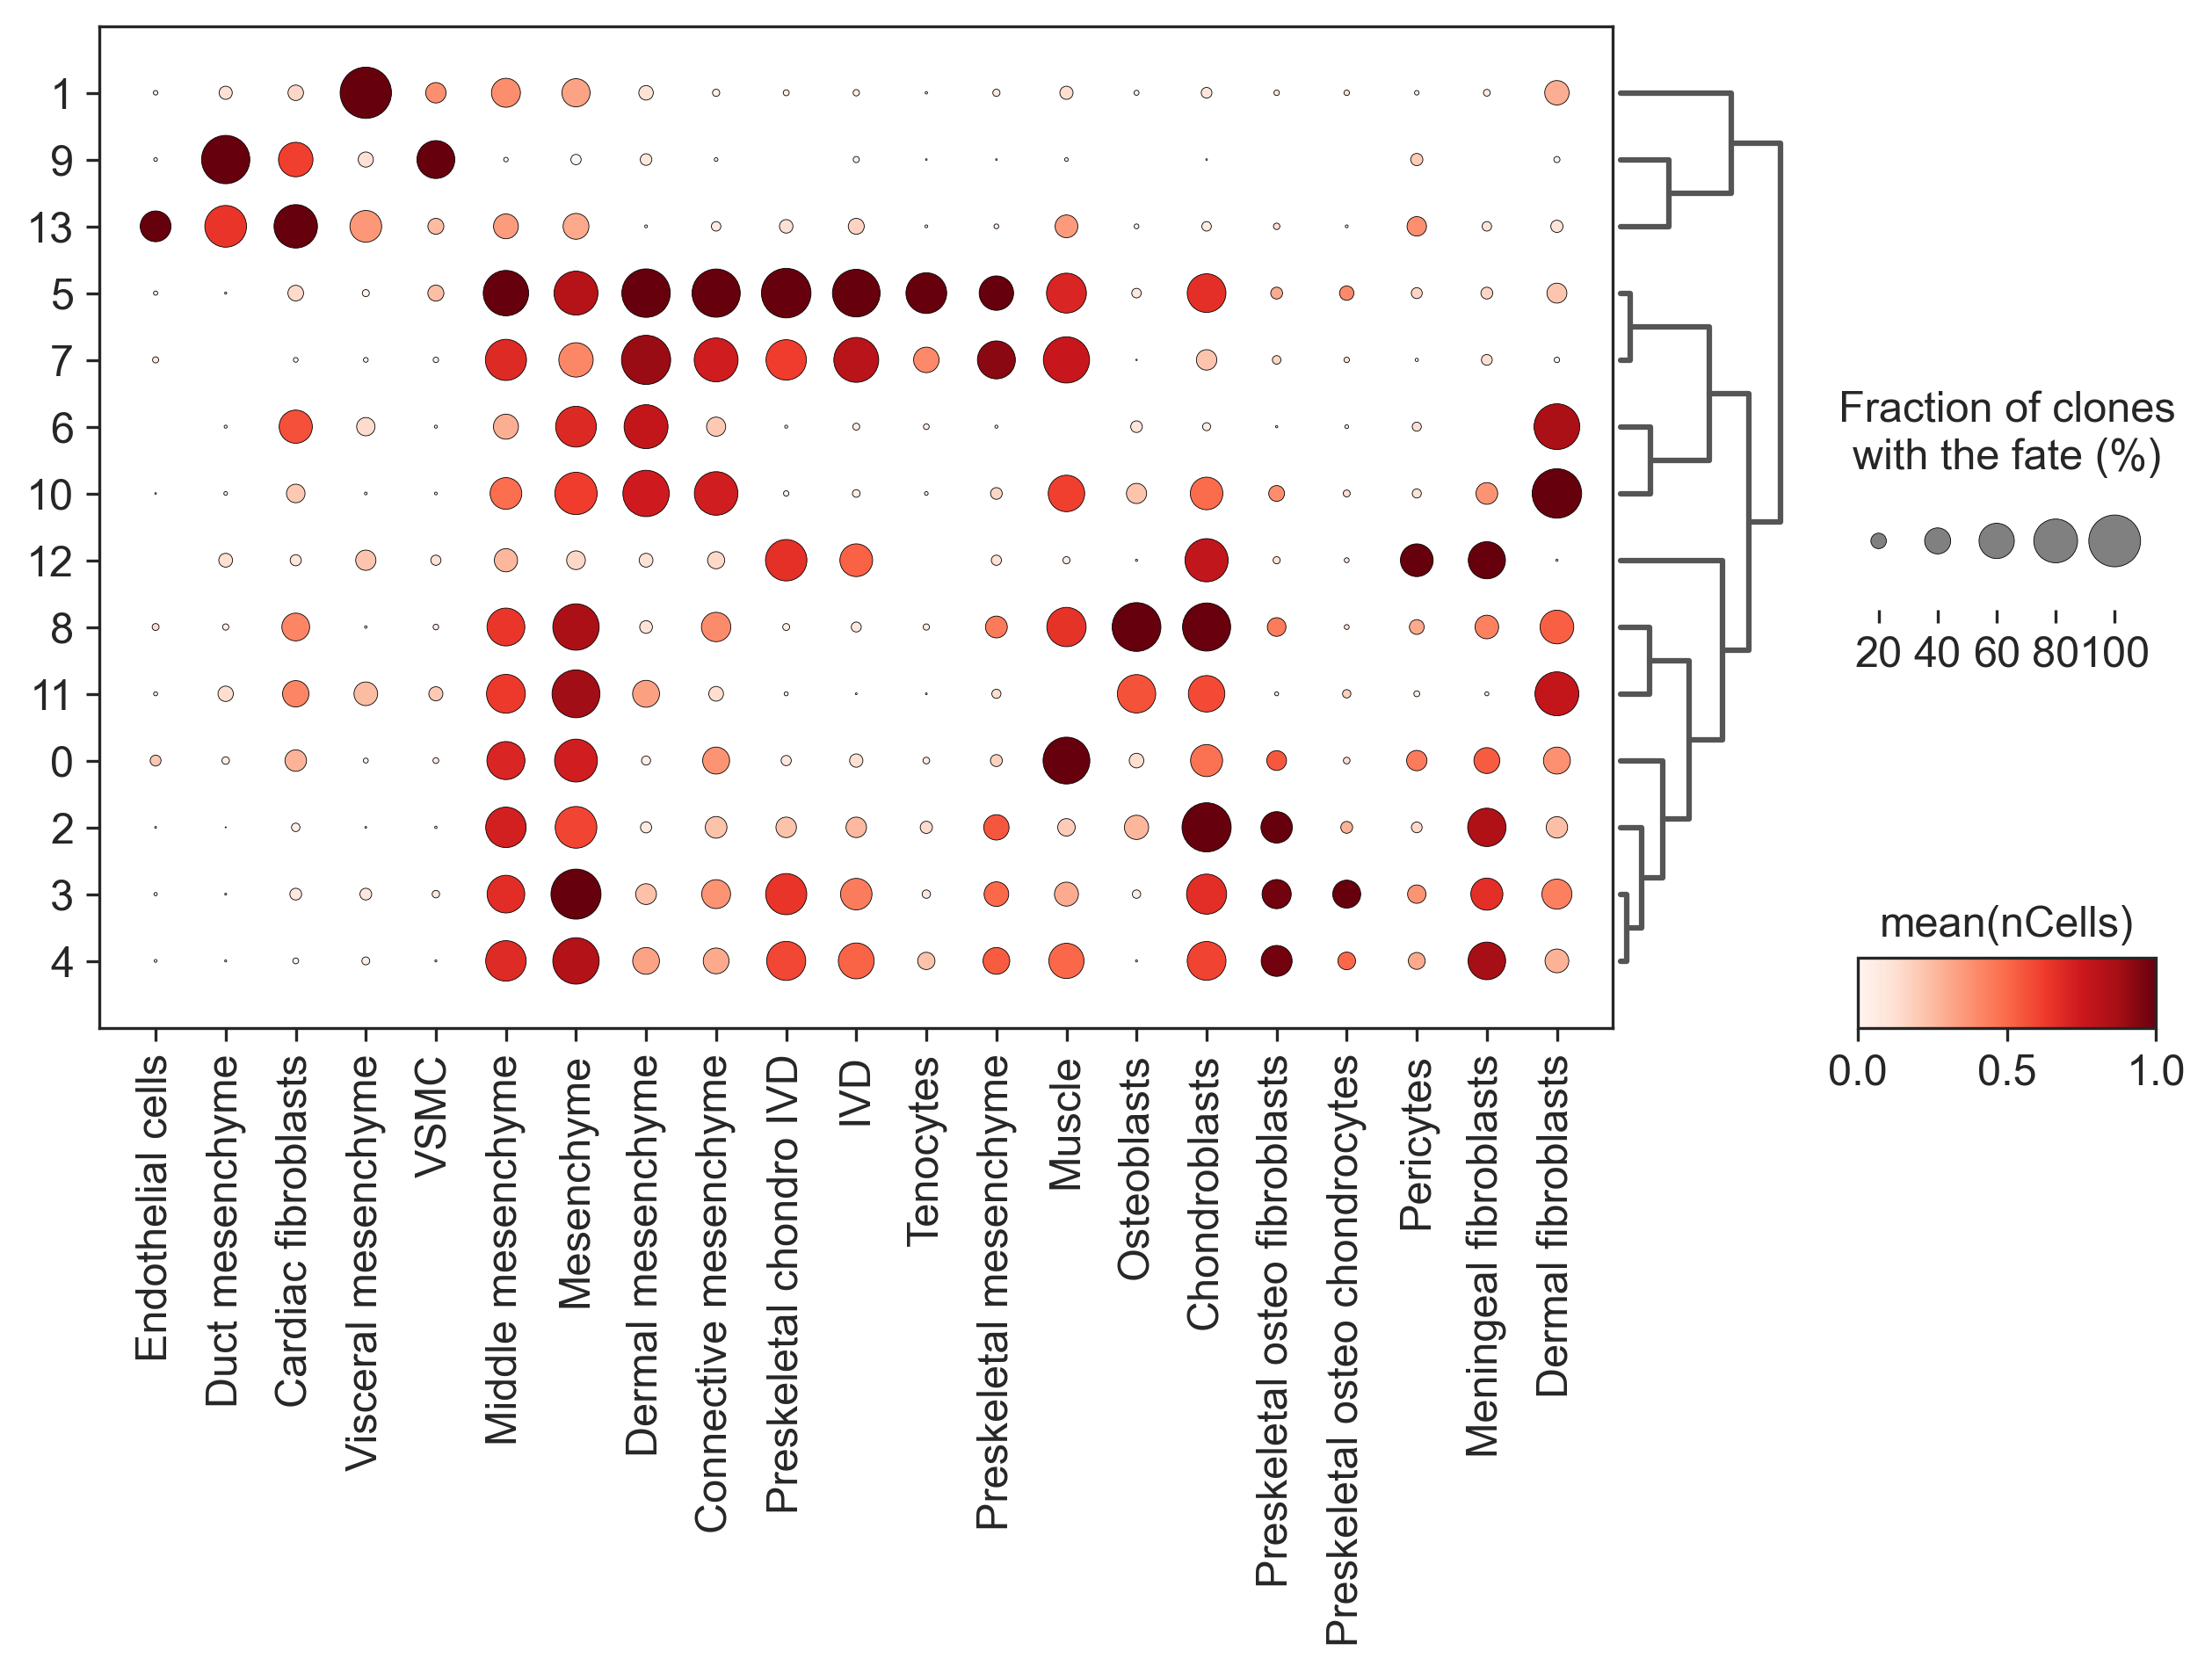

In [948]:
clones_mesenchyme_plot = clones_mesenchyme.copy()

ax = sc.pl.dotplot(
    clones_mesenchyme_plot,
    var_names=ct_order,
    groupby="leiden",
    cmap="Reds",
    dendrogram=True,
    figsize=(10, 5),
    standard_scale="var",
    show=True,
    colorbar_title="mean(nCells)",
    size_title="Fraction of clones\nwith the fate (%)",
    save="perturb_dotplot.pdf",
)

### Subclusters

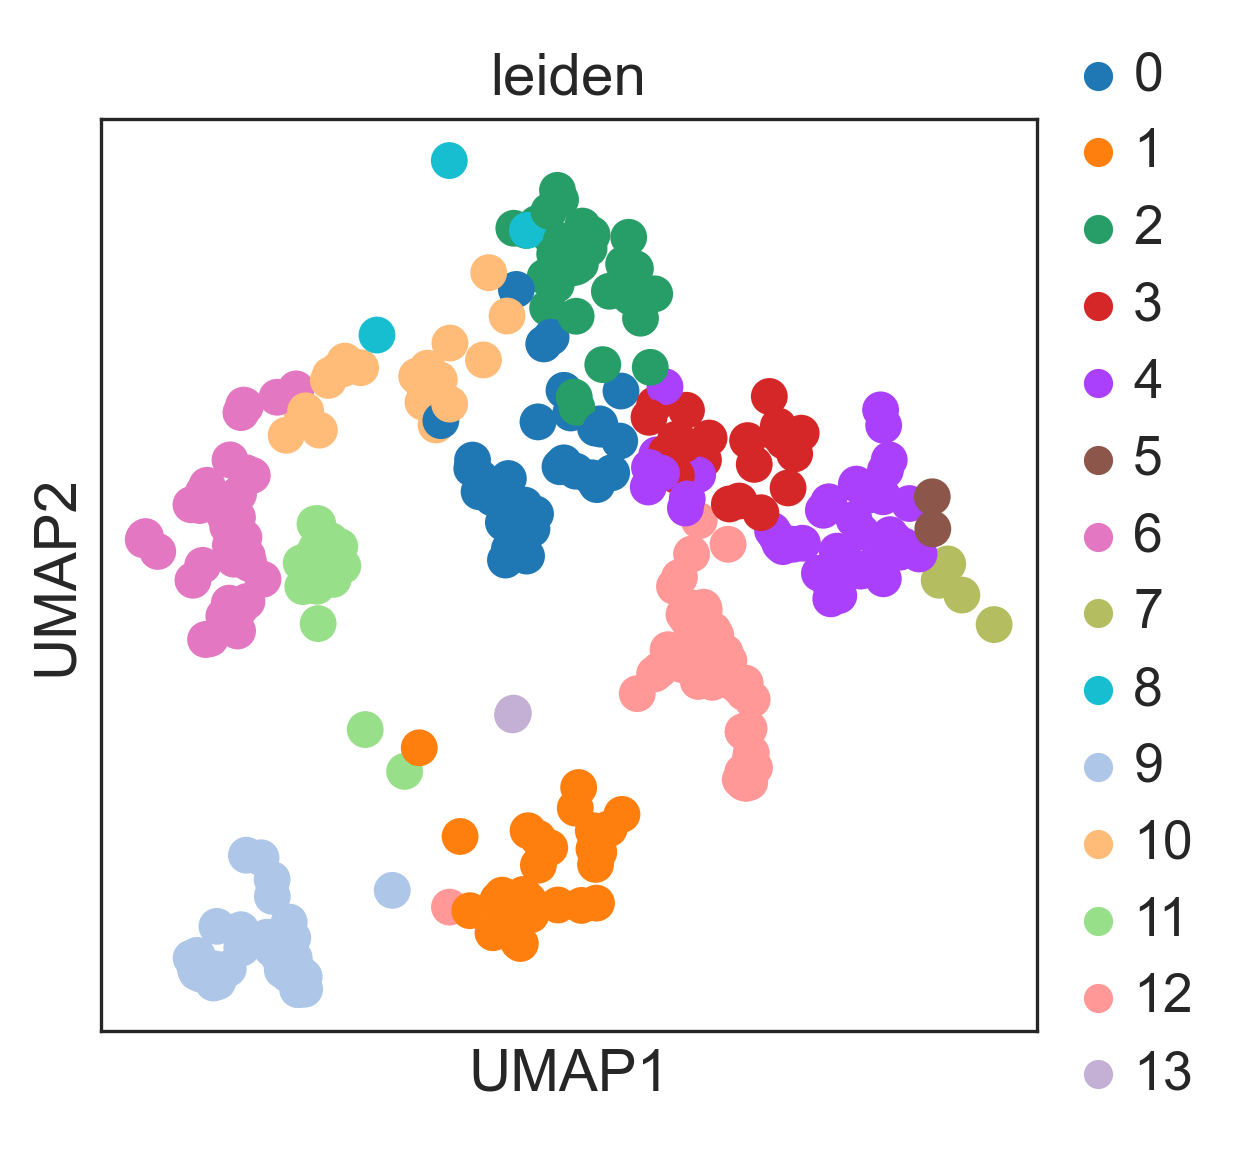

In [136]:
sc.pl.umap(clones_mes_gRNA, color="leiden")

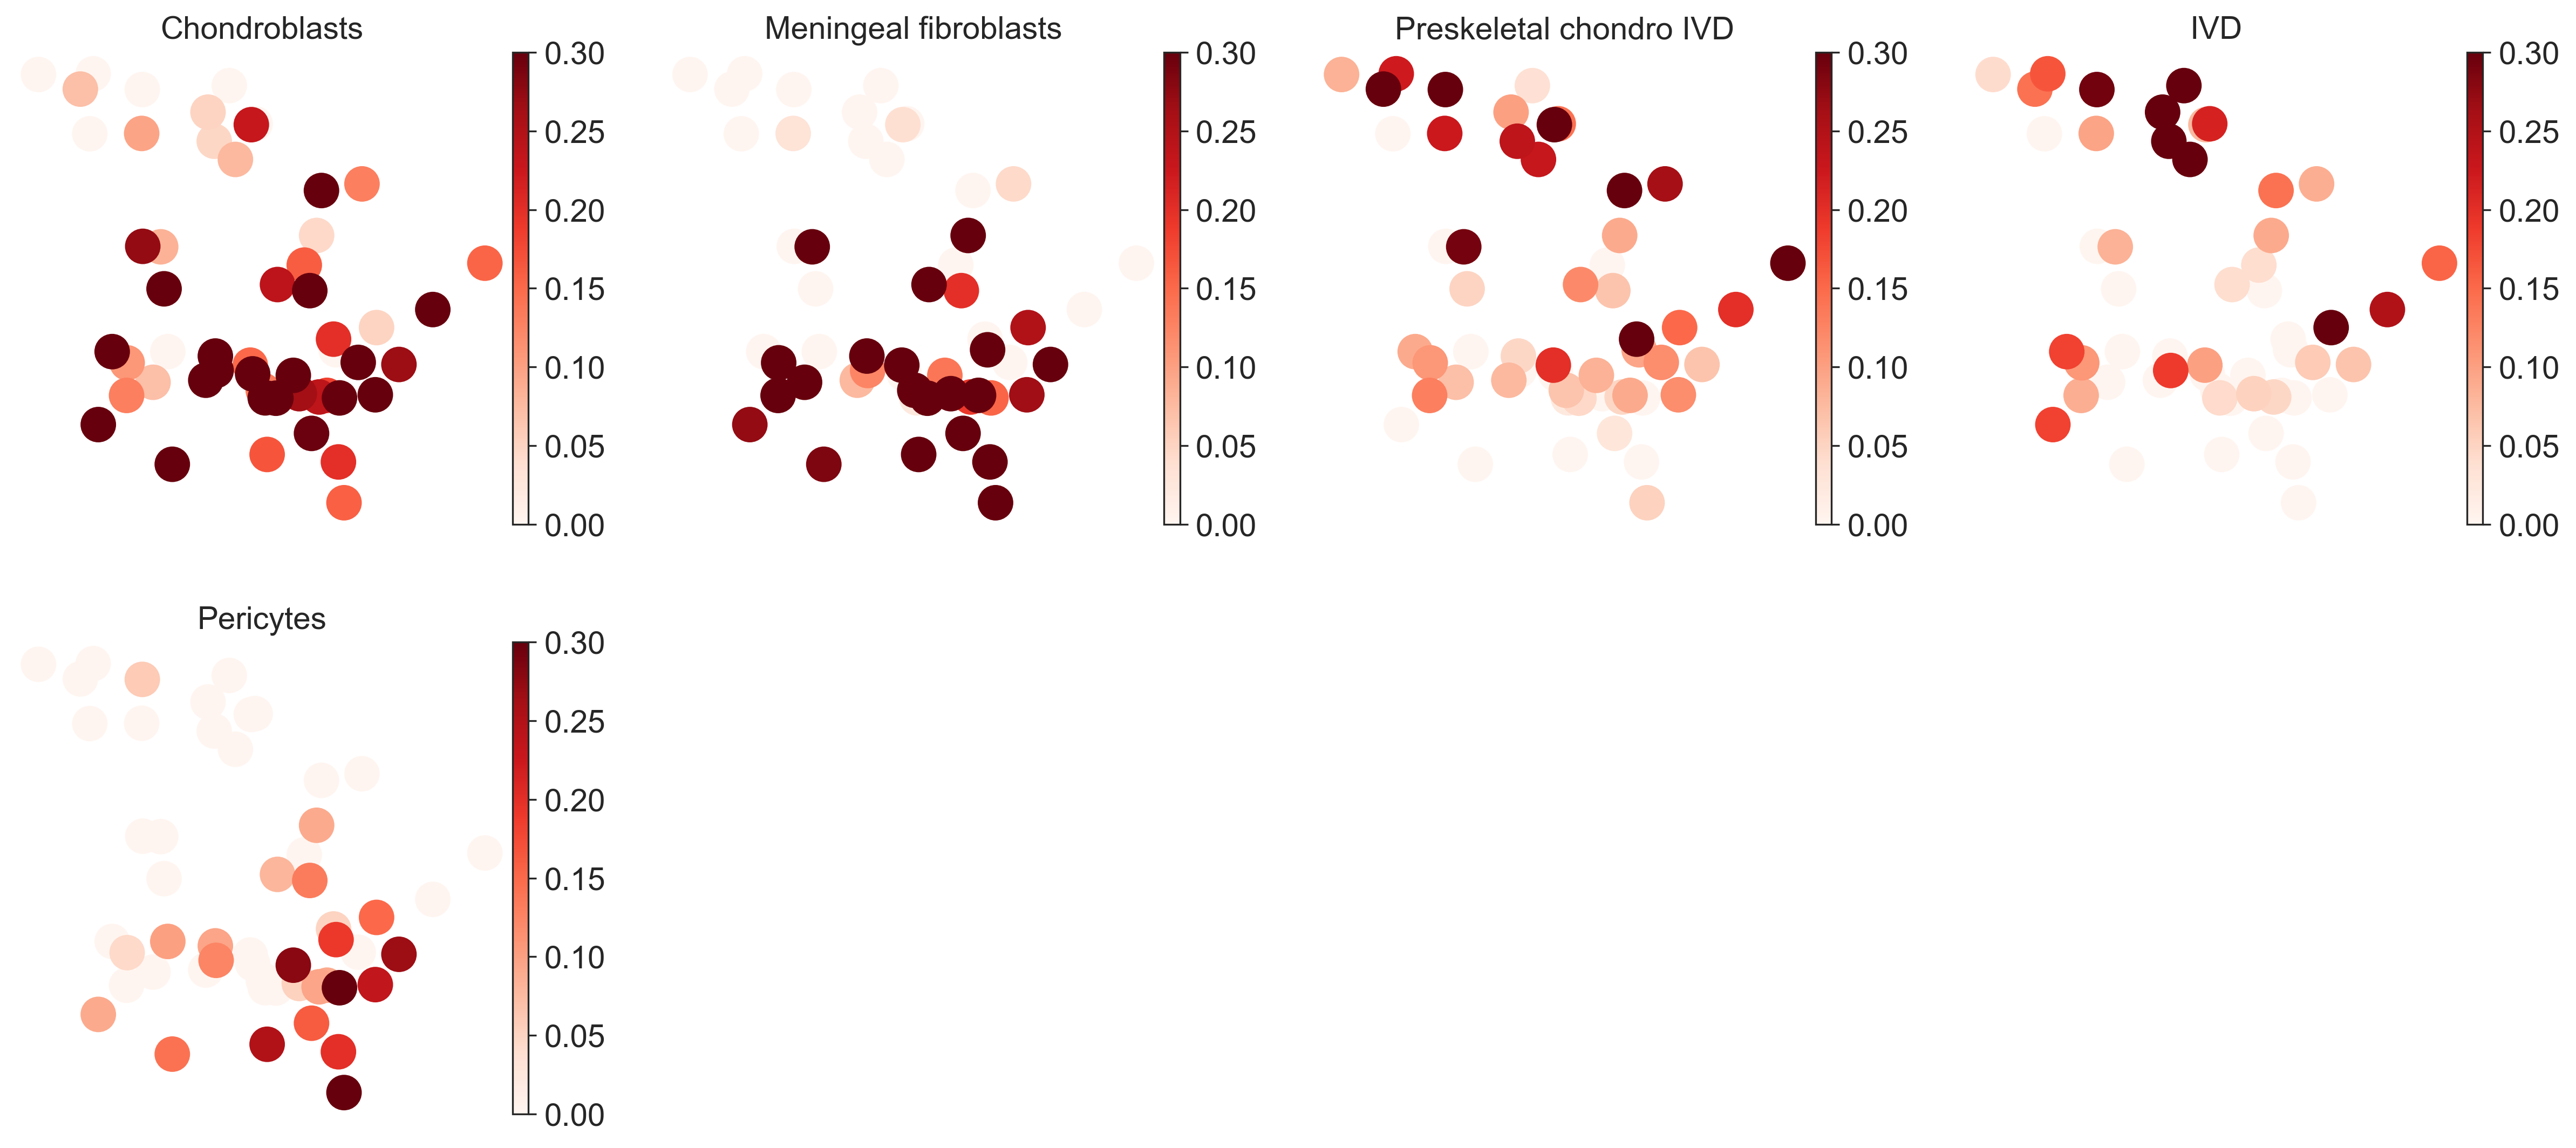

In [132]:
clones_12 = clones_mes_gRNA[clones_mes_gRNA.obs.leiden == "12"]
clones_12 = clones_12[clones_12.obs.perturbation == "Ptch1"]

clones_12.obsm["X_pca"] = sc.pp.pca(clones_12.obsm["word2vec"], n_comps=2, zero_center=False)

sc.pl.pca(clones_12, size=1000, frameon=False, color=[
    "Chondroblasts", "Meningeal fibroblasts", "Preskeletal chondro IVD",
    "IVD", "Pericytes",
], layer="frequencies", vmax=0.3, cmap="Reds")

## Disregulation of Ptch1

In [24]:
clones_LT = clones_mes_gRNA[clones_mes_gRNA.obs.Hox_position > 0.25]
clones_LT = clones_LT[clones_LT.obs.leiden_1 != "9"]

In [25]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.utils import resample

model = KNeighborsRegressor(n_neighbors=5, weights="distance", metric="cosine")
X = clones_LT[clones_LT.obs.perturbation == "EGFP-1"].obsm["word2vec"]
y = clones_LT[clones_LT.obs.perturbation == "EGFP-1"].obs.Hox_position.values
model.fit(X, y)

r2 = {
    "gRNA": [],
    "r2": [],
    "MSE": [],
}

differences = {
    "gRNA": [],
    "RSS": [],
    "TSS": [],
}

for gRNA in set(clones_LT.obs.perturbation):
    X_test = clones_LT[clones_LT.obs.perturbation == gRNA].obsm["word2vec"]
    y_test = clones_LT[clones_LT.obs.perturbation == gRNA].obs.Hox_position.values
    y_pred = model.predict(X_test)
    
    differences["gRNA"] += [gRNA] * len(y_pred)
    differences["RSS"] += list(np.sqrt((y_test - y_pred)**2))
    differences["TSS"] += list(np.sqrt((y_test - y_test.mean())**2))

    r2["r2"].append(r2_score(y_test, y_pred))
    r2["gRNA"].append(gRNA)
    r2["MSE"].append(mean_squared_error(y_test, y_pred))
    
r2 = pd.DataFrame(r2)
differences = pd.DataFrame(differences)
differences["R2"] = differences.RSS / differences.TSS

In [26]:
differences.groupby("gRNA").median()["RSS"].sort_values()[1:].index

Index(['Tgfbr3', 'Bmpr2', 'Lrp4', 'Fzd4', 'Acvrl1', 'Bmpr1a', 'Hhip', 'Ptch1'], dtype='object', name='gRNA')

Text(0.5, 1.0, 'p(Ptch1 vs. Bmpr1a) = 0.026')

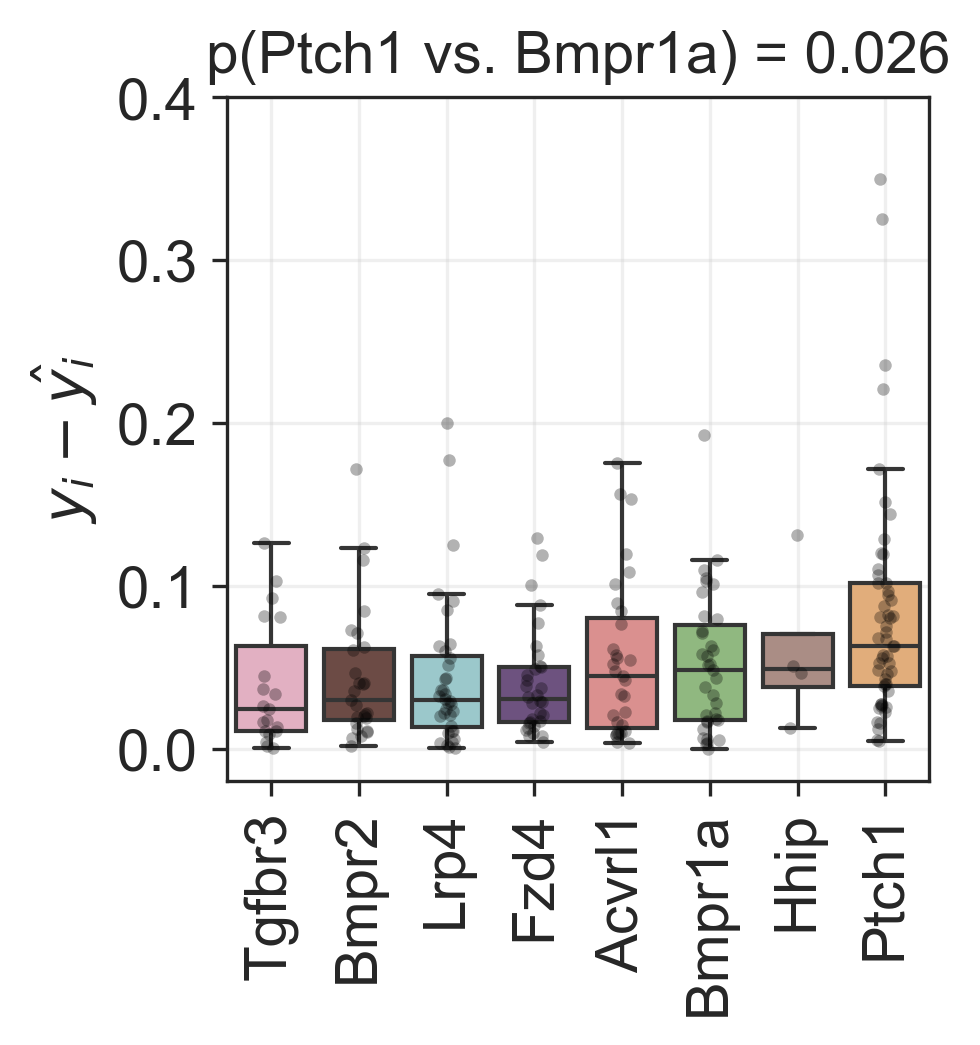

In [28]:
from scipy.stats import mannwhitneyu

fig, ax = plt.subplots(figsize=(3, 3))

sns.boxplot(
    x="gRNA",
    y="RSS",
    data=differences,
    ax=ax,
    showfliers=False,
    palette=dict(zip(
        clones_mes_gRNA.obs.perturbation.cat.categories,
        clones_mes_gRNA.uns["perturbation_colors"],
    )),
    order=differences.groupby("gRNA").median()["RSS"].sort_values()[1:].index
)

sns.stripplot(
    x="gRNA",
    y="RSS",
    data=differences,
    ax=ax,
    color="k",
    alpha=0.3,
    s=3,
    order=differences.groupby("gRNA").median()["RSS"].sort_values()[1:].index
)

ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
ax.grid(alpha=0.3)
ax.set_xlabel("")
ax.set_ylabel(r"$y_i - \hat{y_i}$")
ax.set_ylim(-0.02, 0.4)

p = np.round(mannwhitneyu(
    differences[differences.gRNA == "Ptch1"].RSS,
    differences[differences.gRNA == "Bmpr1a"].RSS,
).pvalue, 3)
ax.set_title(f"p(Ptch1 vs. Bmpr1a) = {p}")

plt.savefig("Ptch1_body_location/kNN_gRNA_vs_control_boxplot.pdf", bbox_inches="tight")

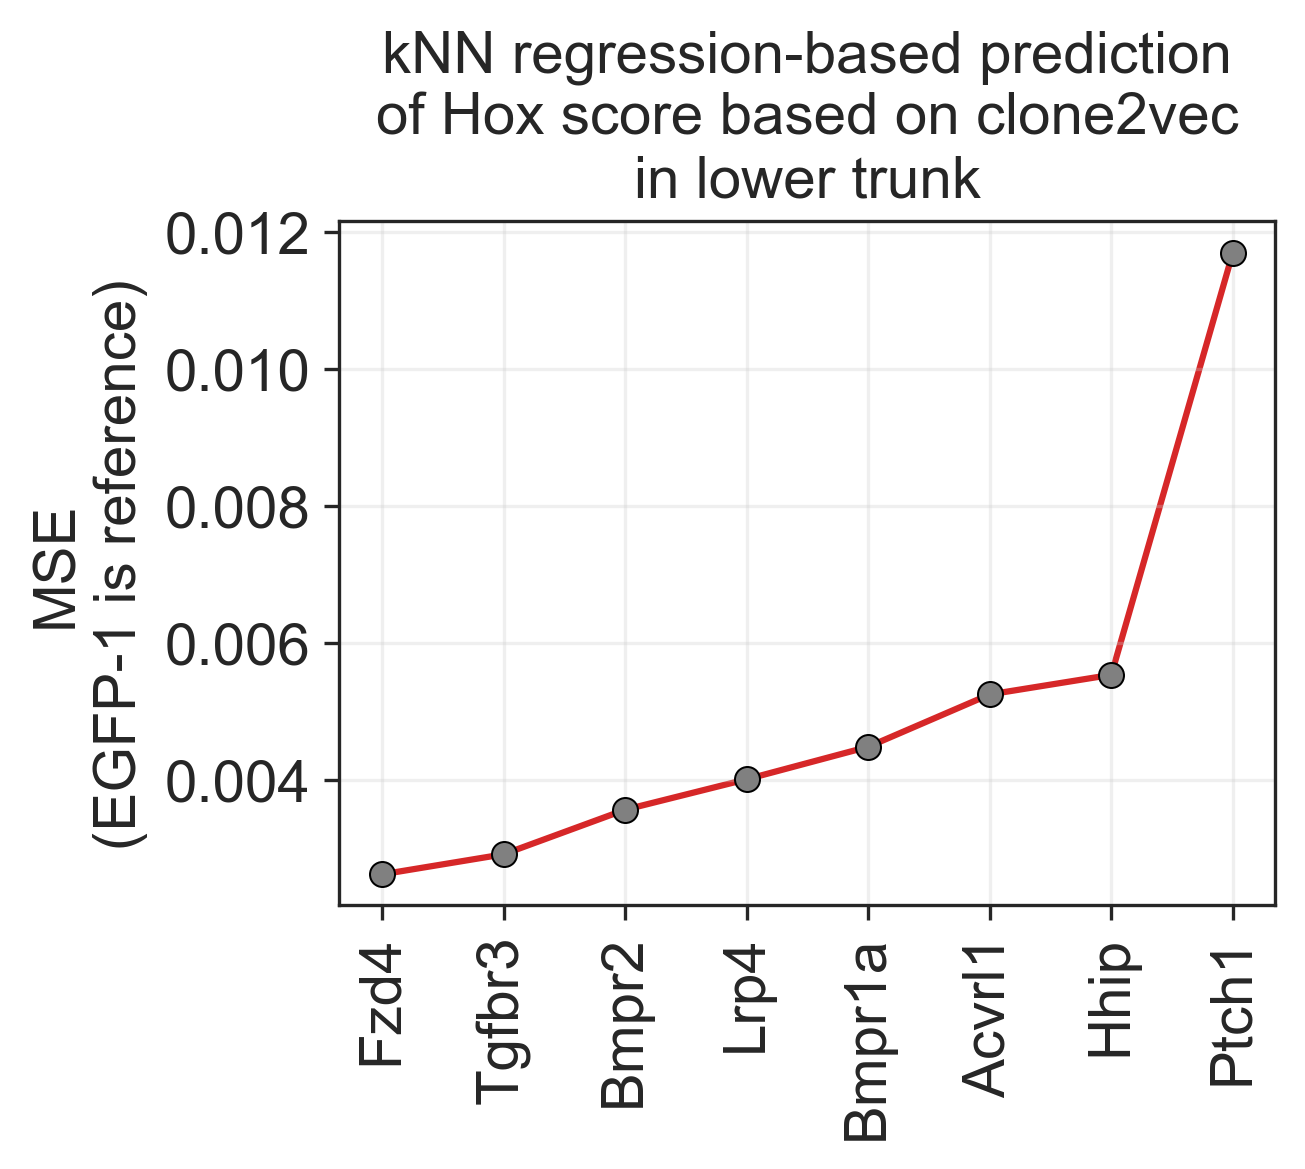

In [403]:
fig, ax = plt.subplots(figsize=(4, 3))

sns.lineplot(
    x="gRNA",
    y="MSE",
    data=r2.sort_values("MSE").iloc[1:],
    ax=ax,
    color=sns.color_palette()[3],
    zorder=-1,
)

sns.scatterplot(
    x="gRNA",
    y="MSE",
    data=r2.sort_values("MSE").iloc[1:],
    ax=ax,
    color="grey",
    edgecolor="black",
)

ax.set_xlabel("")
ax.set_ylabel("MSE\n(EGFP-1 is reference)")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
ax.grid(alpha=0.3)
#ax.set_ylim(-1, 1)

ax.set_title("kNN regression-based prediction\nof Hox score based on clone2vec\nin lower trunk")

plt.savefig("Ptch1_body_location/kNN_gRNA_vs_control.pdf", bbox_inches="tight")

In [29]:
n_neighbors = 5

r2_gRNA = {
    "gRNA": [],
    "r2": [],
}

for gRNA in set(clones_LT.obs.perturbation):
    clones_LT_gRNA = clones_LT[clones_LT.obs.perturbation == gRNA]
    if len(clones_LT_gRNA) > 30:
        model = KNeighborsRegressor(n_neighbors=5, weights="distance", metric="cosine")
        y_pred = np.array([
            model.fit(
                np.delete(clones_LT_gRNA.obsm["word2vec"], i, axis=0),
                np.delete(clones_LT_gRNA.obs.Hox_position.values, i),
            ).predict(clones_LT_gRNA.obsm["word2vec"][i].reshape(1, -1))[0]
            for i in range(len(clones_LT_gRNA))
        ])
        y_test = clones_LT_gRNA.obs.Hox_position.values
        
        r2_gRNA["r2"].append(r2_score(y_test, y_pred))
        r2_gRNA["gRNA"].append(gRNA)
    
r2_gRNA = pd.DataFrame(r2_gRNA)
r2_gRNA = r2_gRNA.sort_values("r2")

Text(0.5, 1.0, 'kNN regression-based prediction\nof Hox score based on clone2vec\nin lower trunk')

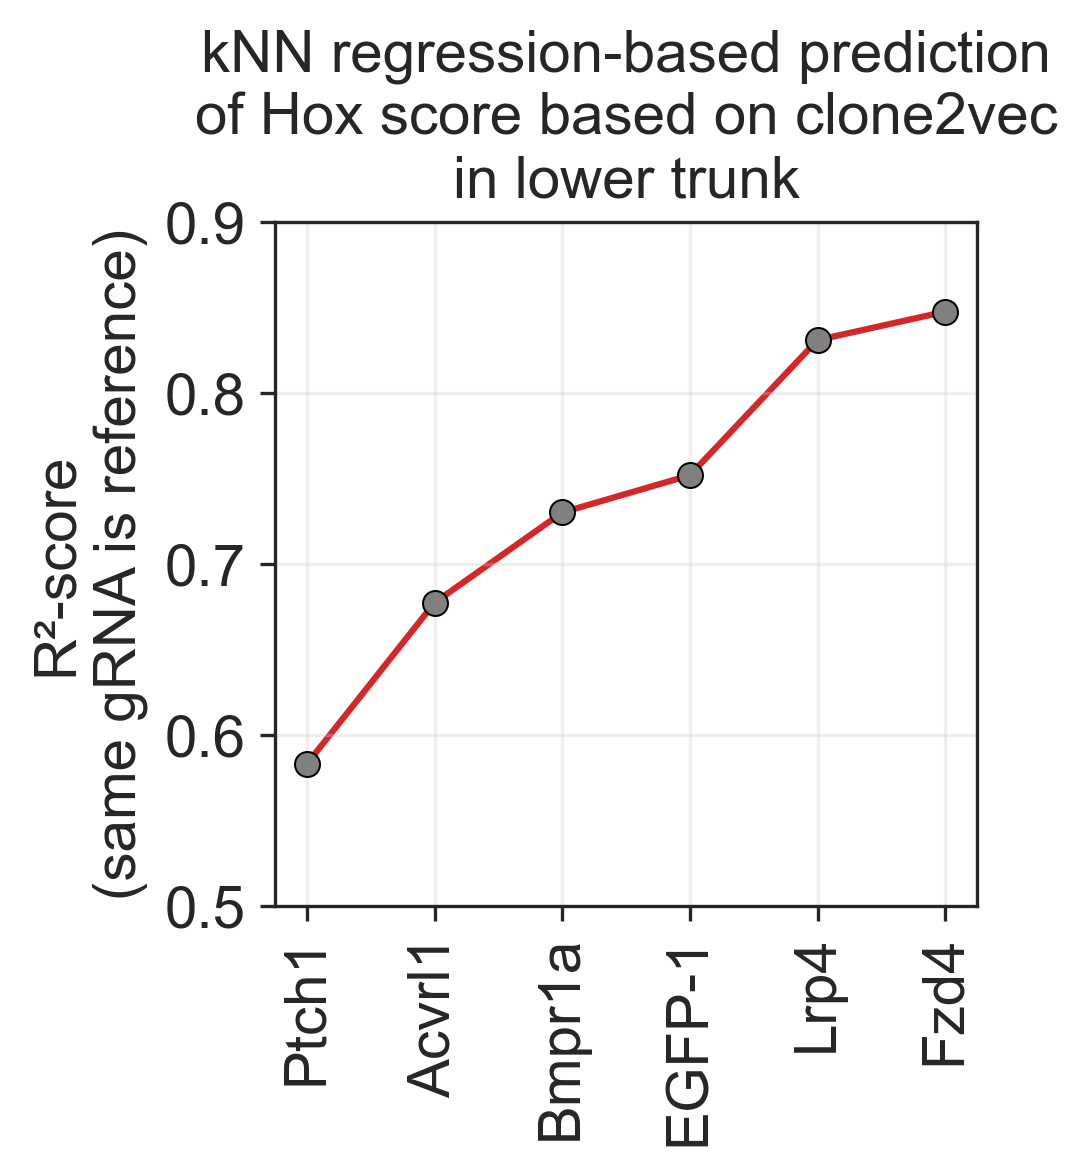

In [30]:
fig, ax = plt.subplots(figsize=(3, 3))

sns.lineplot(
    x="gRNA",
    y="r2",
    data=r2_gRNA,
    ax=ax,
    color=sns.color_palette()[3],
    zorder=-1,
    estimator=None,
)

sns.scatterplot(
    x="gRNA",
    y="r2",
    data=r2_gRNA,
    ax=ax,
    color="grey",
    edgecolor="black",
)

ax.set_xlabel("")
ax.set_ylabel("R²-score\n(same gRNA is reference)")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
ax.grid(alpha=0.3)
ax.set_ylim(0.5, 0.9)

ax.set_title("kNN regression-based prediction\nof Hox score based on clone2vec\nin lower trunk")
plt.savefig("Ptch1_body_location/kNN_gRNA_vs_gRNA.pdf", bbox_inches="tight")

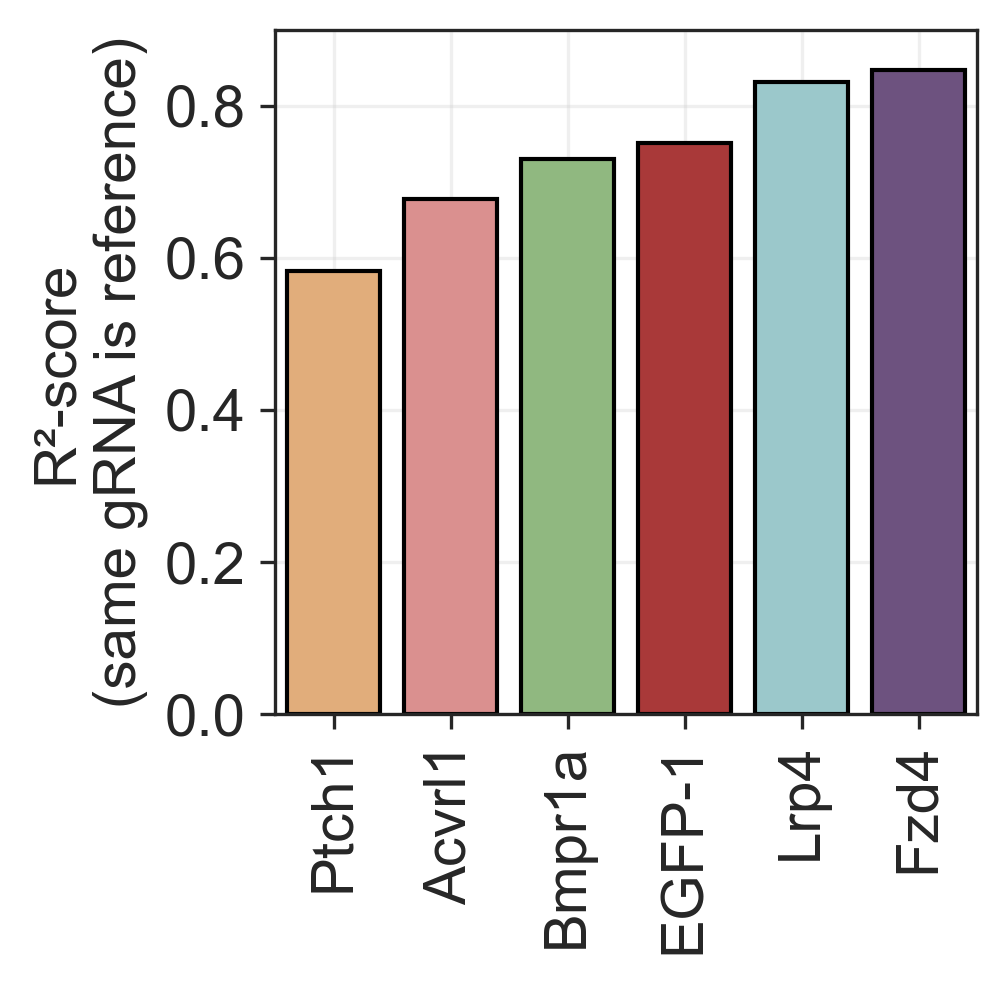

In [36]:
fig, ax = plt.subplots(figsize=(3, 3))

sns.barplot(
    x="gRNA",
    y="r2",
    data=r2_gRNA,
    ax=ax,
    color="lightgrey",
    edgecolor="black",
    palette=perturbation_colors,
)

ax.set_xlabel("")
ax.set_ylabel("R²-score\n(same gRNA is reference)")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
ax.grid(alpha=0.3)
ax.set_ylim(0, 0.9)

plt.savefig("Ptch1_body_location/kNN_gRNA_vs_gRNA_bar.pdf", bbox_inches="tight")

In [423]:
from scipy.stats import pearsonr

corr_PC = {
    "gRNA": [],
    "stat": [],
    "p": [],
}

for gRNA in set(clones_LT.obs.perturbation):
    clones_LT_gRNA = clones_LT[clones_LT.obs.perturbation == gRNA]
    clones_LT_gRNA.obs["PC1"] = sc.pp.pca(clones_LT_gRNA.obsm["word2vec"], n_comps=1).T[0]
    stat, p = pearsonr(
        clones_LT_gRNA.obs.Hox_position.values,
        clones_LT_gRNA.obs.PC1.values
    )
    corr_PC["gRNA"].append(gRNA)
    corr_PC["stat"].append(stat)
    corr_PC["p"].append(p)
        
corr_PC = pd.DataFrame(corr_PC)
corr_PC["stat"] = np.abs(corr_PC.stat)
corr_PC = corr_PC.sort_values("stat")
corr_PC = corr_PC.reset_index(drop=True)

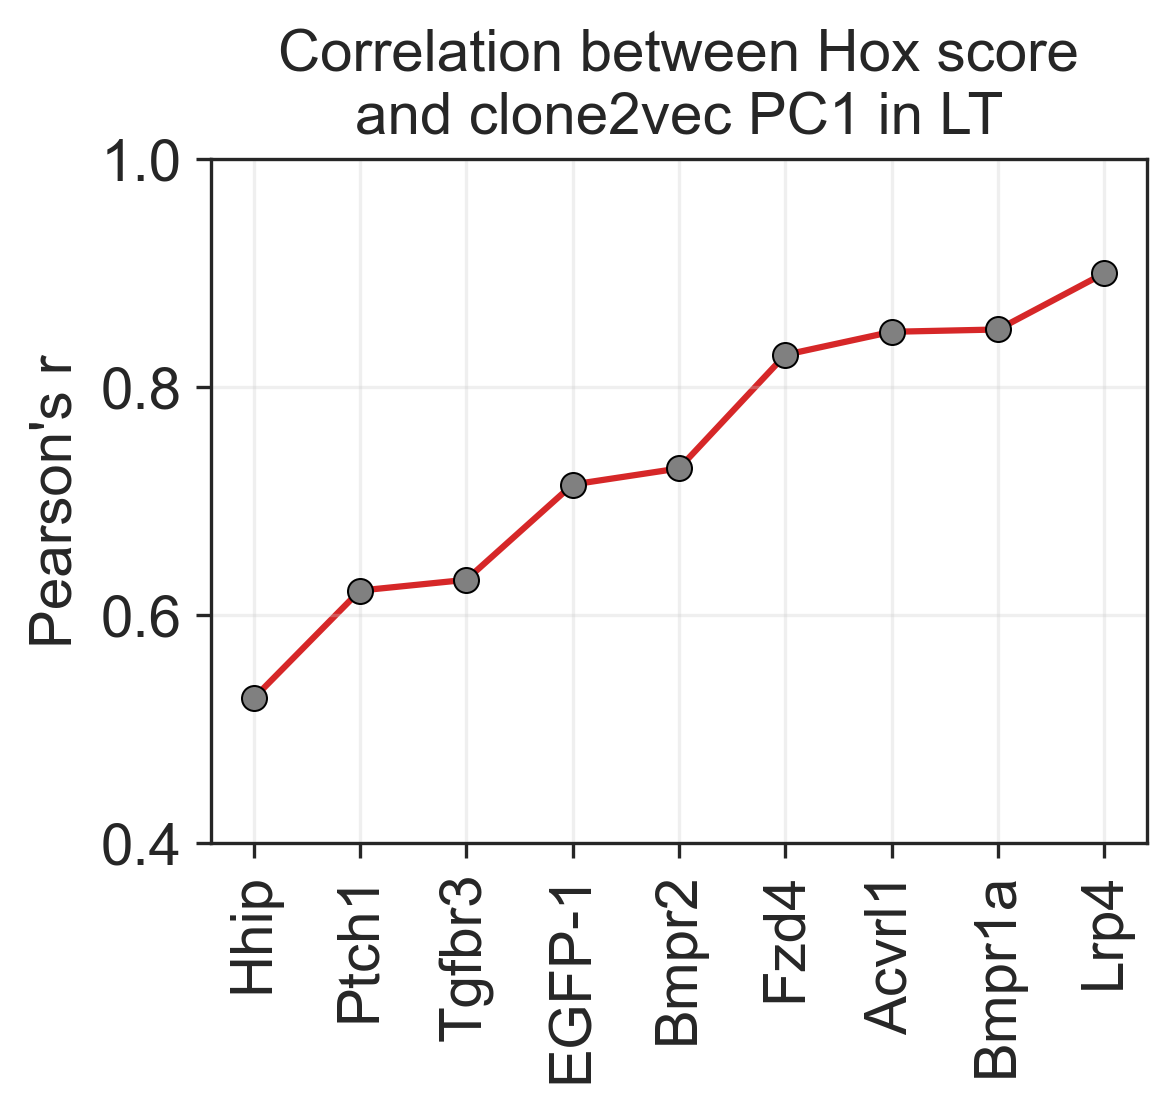

In [427]:
fig, ax = plt.subplots(figsize=(4, 3))

sns.lineplot(
    x="gRNA",
    y="stat",
    data=corr_PC,
    ax=ax,
    color=sns.color_palette()[3],
    zorder=-1,
    estimator=None,
)

sns.scatterplot(
    x="gRNA",
    y="stat",
    data=corr_PC,
    ax=ax,
    color="grey",
    edgecolor="black",
)

ax.set_xlabel("")
ax.set_ylabel("Pearson's r")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
ax.grid(alpha=0.3)
ax.set_ylim(0.4, 1)

ax.set_title("Correlation between Hox score\nand clone2vec PC1 in LT")
plt.savefig("Ptch1_body_location/corr_gRNA_vs_gRNA.pdf", bbox_inches="tight")

## Spatial location

In [31]:
def flip_vertically(matrix):
    min_range = matrix[:, 1].min()
    max_range = matrix[:, 1].max()
    
    new_matrix = matrix.copy()
    new_matrix[:, 1] = max_range - matrix[:, 1] + min_range
    return new_matrix

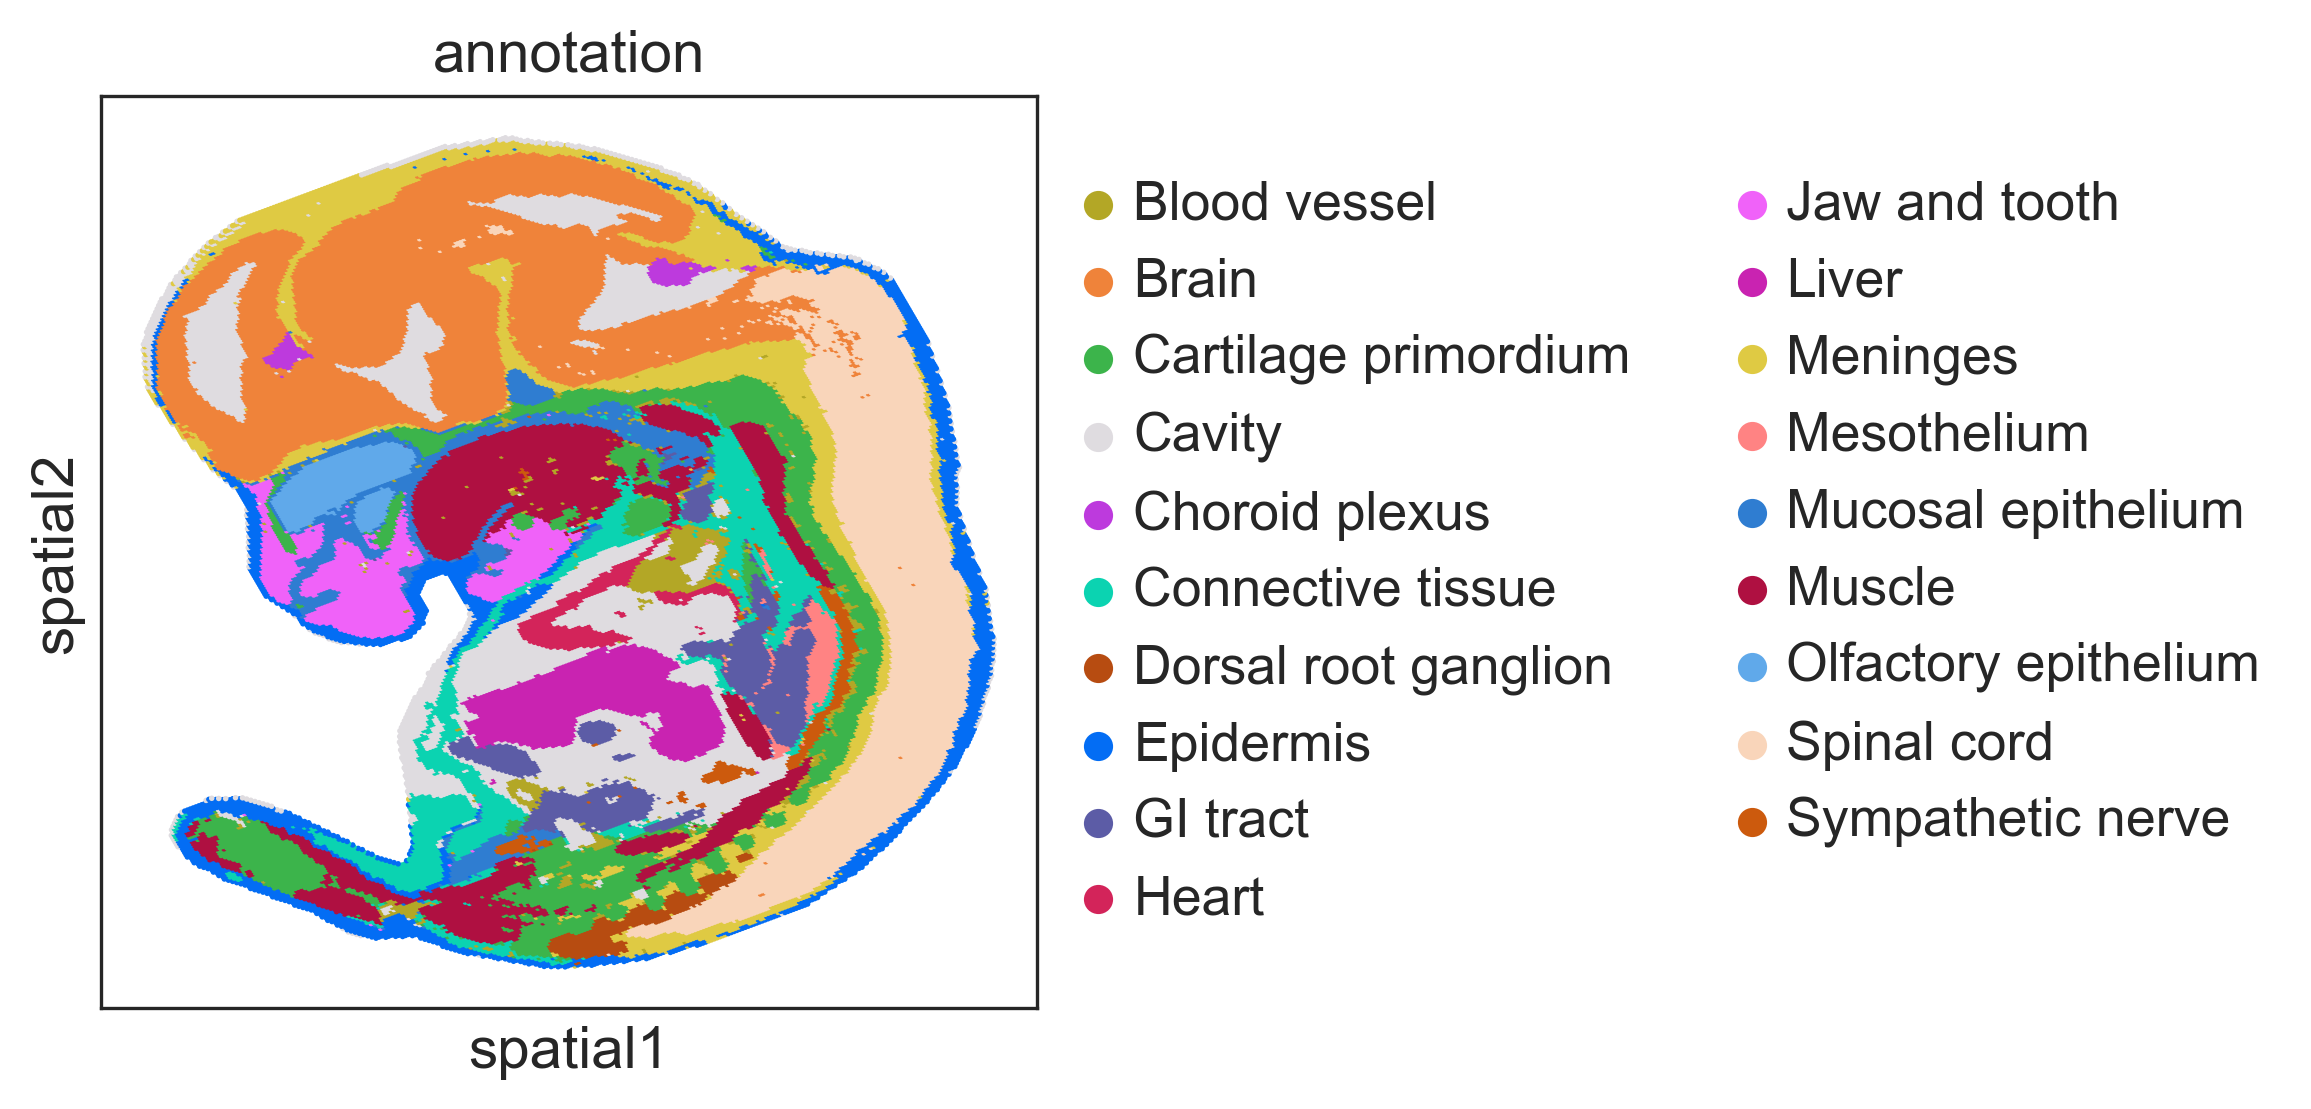

In [32]:
spatial = sc.read_h5ad("/home/sergey/disk/mouse_spatial/E13/E13.5_E1S2.MOSTA.h5ad")
spatial.obsm["spatial"] = flip_vertically(spatial.obsm["spatial"])
sc.pl.embedding(spatial, basis="spatial", color="annotation", s=7)

In [33]:
clones_expr_mes = clones_expr[clones_mesenchyme.obs_names]
clones_expr_mes.obs["leiden"] = clones_mesenchyme.obs.leiden

sc.tl.rank_genes_groups(clones_expr_mes, groupby="leiden")

In [34]:
min_logfc = 4
max_fdr = 1e-5

markers = sc.get.rank_genes_groups_df(clones_expr_mes, group="9")
marker_genes = markers[(markers.pvals_adj < max_fdr) & (markers.logfoldchanges > min_logfc)].names.values

marker_genes

array(['Tcf21', 'Ednrb', 'Slc38a5', 'Fam162b', 'Gata5', 'Car2',
       'Adamdec1', 'Rhox5', 'Asz1', 'Cpb1', 'Lrrc55', 'Gata4', 'Gm41030'],
      dtype=object)

In [35]:
sc.tl.score_genes(
    spatial,
    gene_list=marker_genes,
    score_name="score_9",
)

In [37]:
fig, ax = plt.subplots(figsize=(4, 5))
sc.pl.embedding(spatial, basis="spatial", color="score_9", s=5, ax=ax, vmin=0, vmax=0.5,
                show=False, title="Clonal cluster 9\nsignature score", frameon=False,
                save="spatial_cluster9.pdf")

<Axes: title={'center': 'Clonal cluster 9\nsignature score'}, xlabel='spatial1', ylabel='spatial2'>

In [969]:
min_logfc = 3
max_fdr = 1e-10

markers = sc.get.rank_genes_groups_df(clones_expr_mes, group="12")
marker_genes = markers[(markers.pvals_adj < max_fdr) & (markers.logfoldchanges > min_logfc)].names.values

marker_genes

array(['Foxf2', 'Foxl1', 'Hhip', '1700018A04Rik', 'Gm5127', 'Fendrr',
       'Apod', 'Saa1'], dtype=object)

In [970]:
sc.tl.score_genes(
    spatial,
    gene_list=marker_genes,
    score_name="score_12",
)

<Axes: title={'center': 'Clonal cluster 12\nsignature score'}, xlabel='spatial1', ylabel='spatial2'>

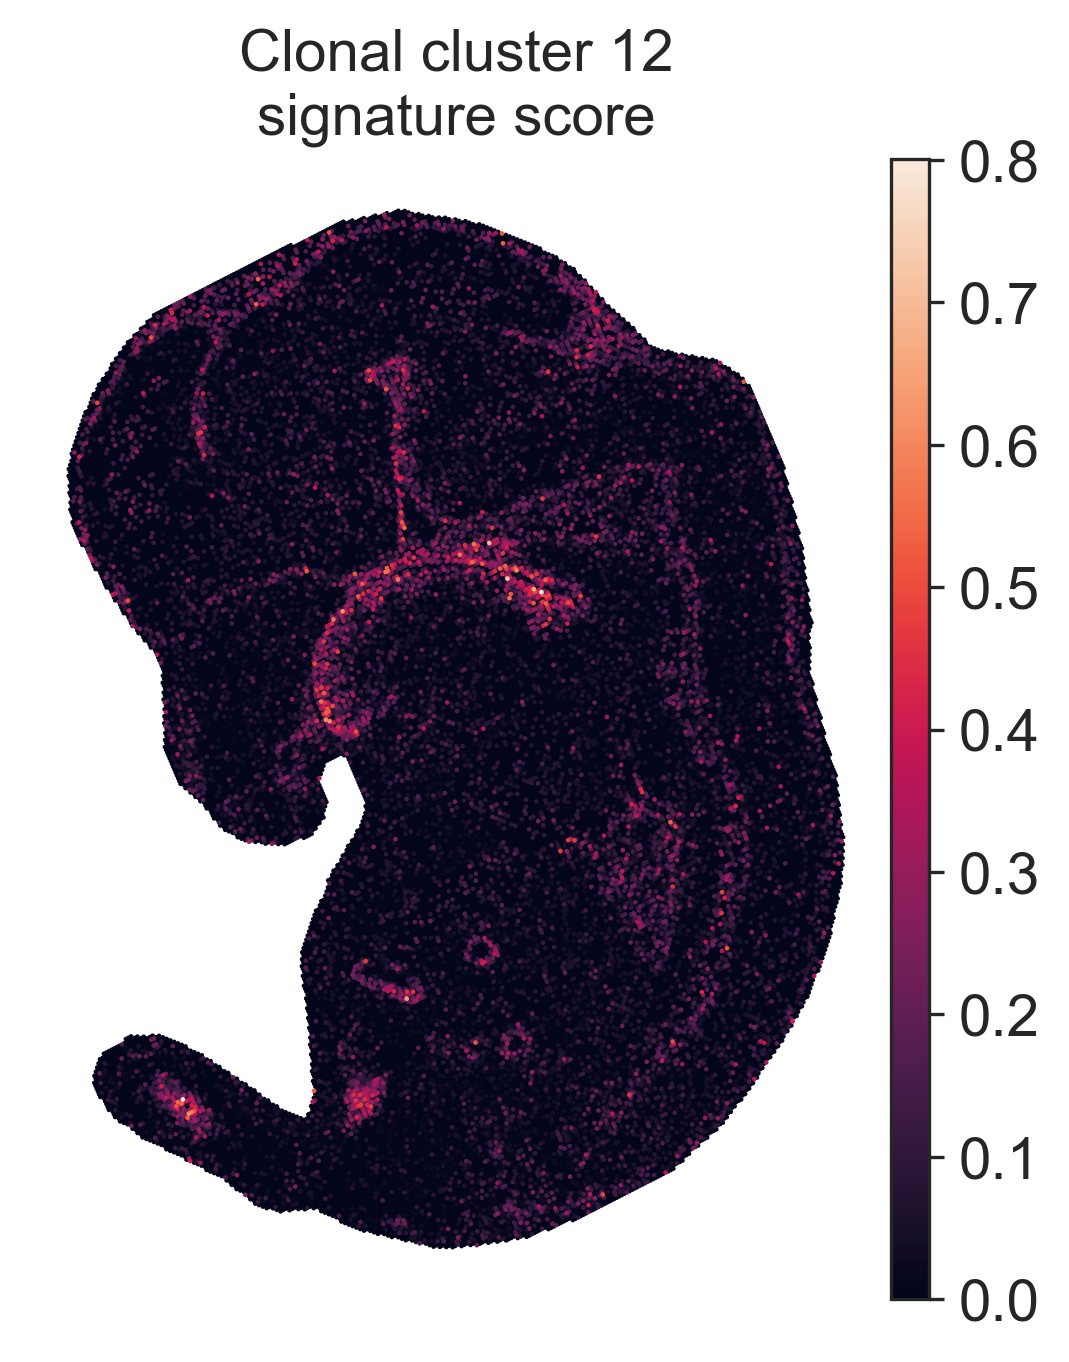

In [971]:
fig, ax = plt.subplots(figsize=(4, 5))
sc.pl.embedding(spatial, basis="spatial", color="score_12", s=5, ax=ax, vmin=0,
                show=False, title="Clonal cluster 12\nsignature score", frameon=False,
                ) # save="spatial_cluster9.pdf")

In [437]:
genes = np.array([
    "Hoxc13", "Hoxc12", "Hoxc11",
    "Hoxd11", "Hoxc10", "Hoxd9",
    "Hoxc8", "Hoxa7", "Hoxc6", "Hoxb5",
    "Hoxb4"
])

anterio_posterior_signature = dict(enumerate(genes[::-1]))
anterio_posterior_signature = dict(zip(anterio_posterior_signature.values(), [i + 1 for i in anterio_posterior_signature.keys()]))

spatial.obs["Hox_score"] = (
    spatial[:, list(anterio_posterior_signature.keys())].X *
    np.array(list(anterio_posterior_signature.values())) / 
    spatial[:, list(anterio_posterior_signature.keys())].X.sum(axis=1).T.A
)[0]

spatial.obs["Hox_score"] = (
    spatial.obs["Hox_score"] - spatial.obs["Hox_score"].min()
) / (spatial.obs["Hox_score"].max() - spatial.obs["Hox_score"].min())

<Axes: title={'center': 'Hox_score'}, xlabel='spatial1', ylabel='spatial2'>

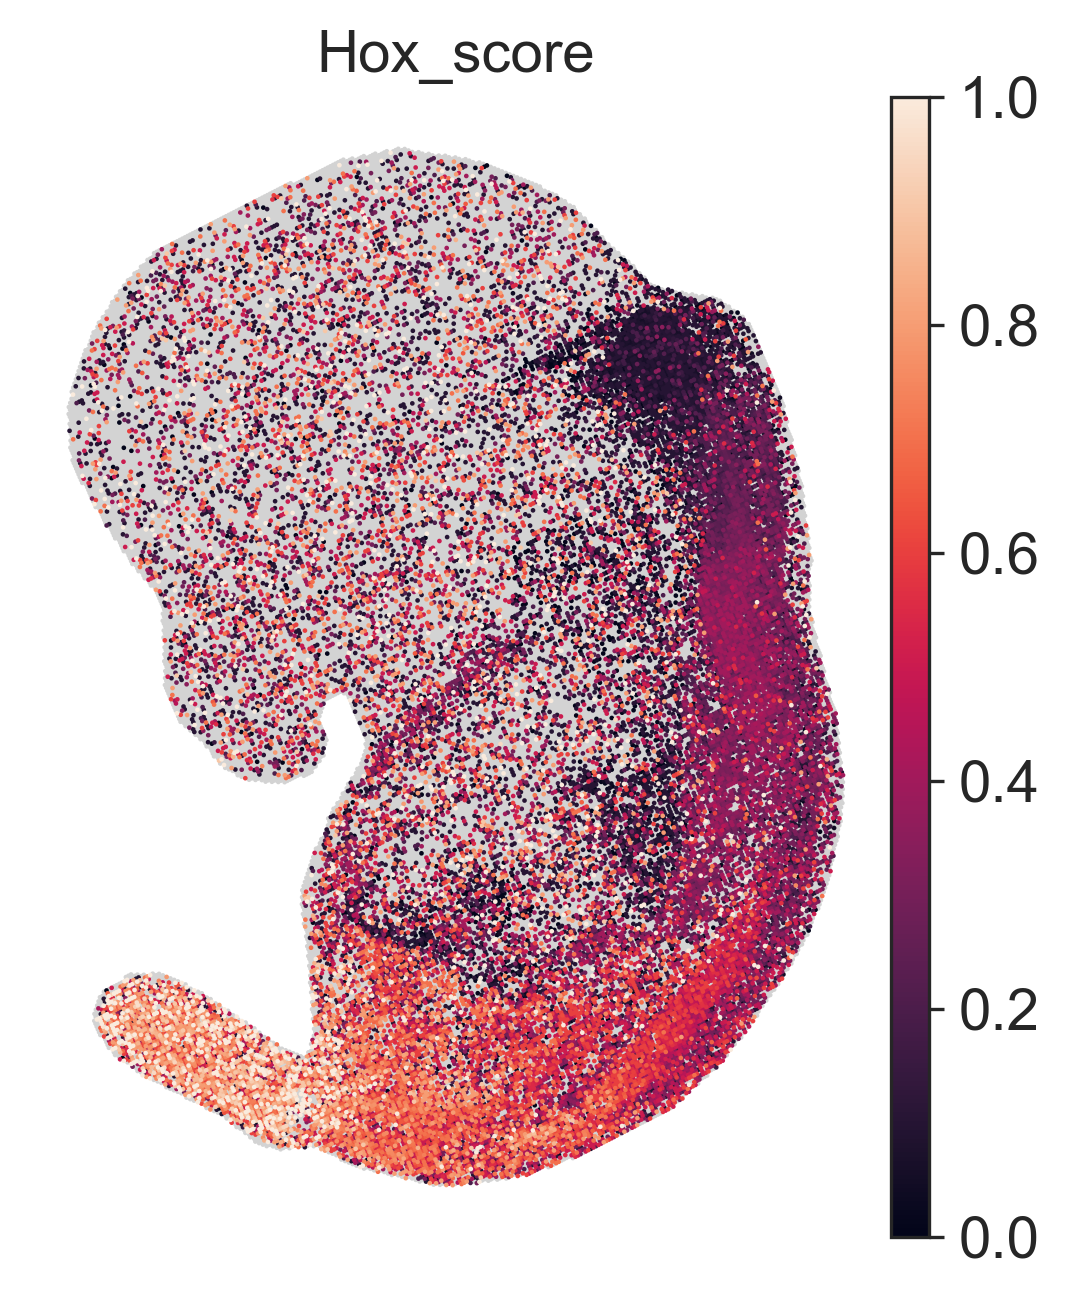

In [438]:
fig, ax = plt.subplots(figsize=(4, 5))
sc.pl.embedding(spatial, color="Hox_score", basis="spatial", s=5, ax=ax, show=False, frameon=False)

In [440]:
sc.pp.neighbors(
    spatial,
    use_rep="spatial",
    n_neighbors=9,
)

In [483]:
def impute(scores):
    if np.isnan(scores).sum() >= 6:
        return np.nan
    else:
        return np.nanmean(scores)

spatial.obs["Hox_imputed"] = [
    impute(spatial.obs.Hox_score[np.argwhere(spatial.obsp["distances"][i] > 0).T[1]].values)
    for i in range(len(spatial))
]

<Axes: title={'center': 'kNN-imputed Hox-score'}, xlabel='spatial1', ylabel='spatial2'>

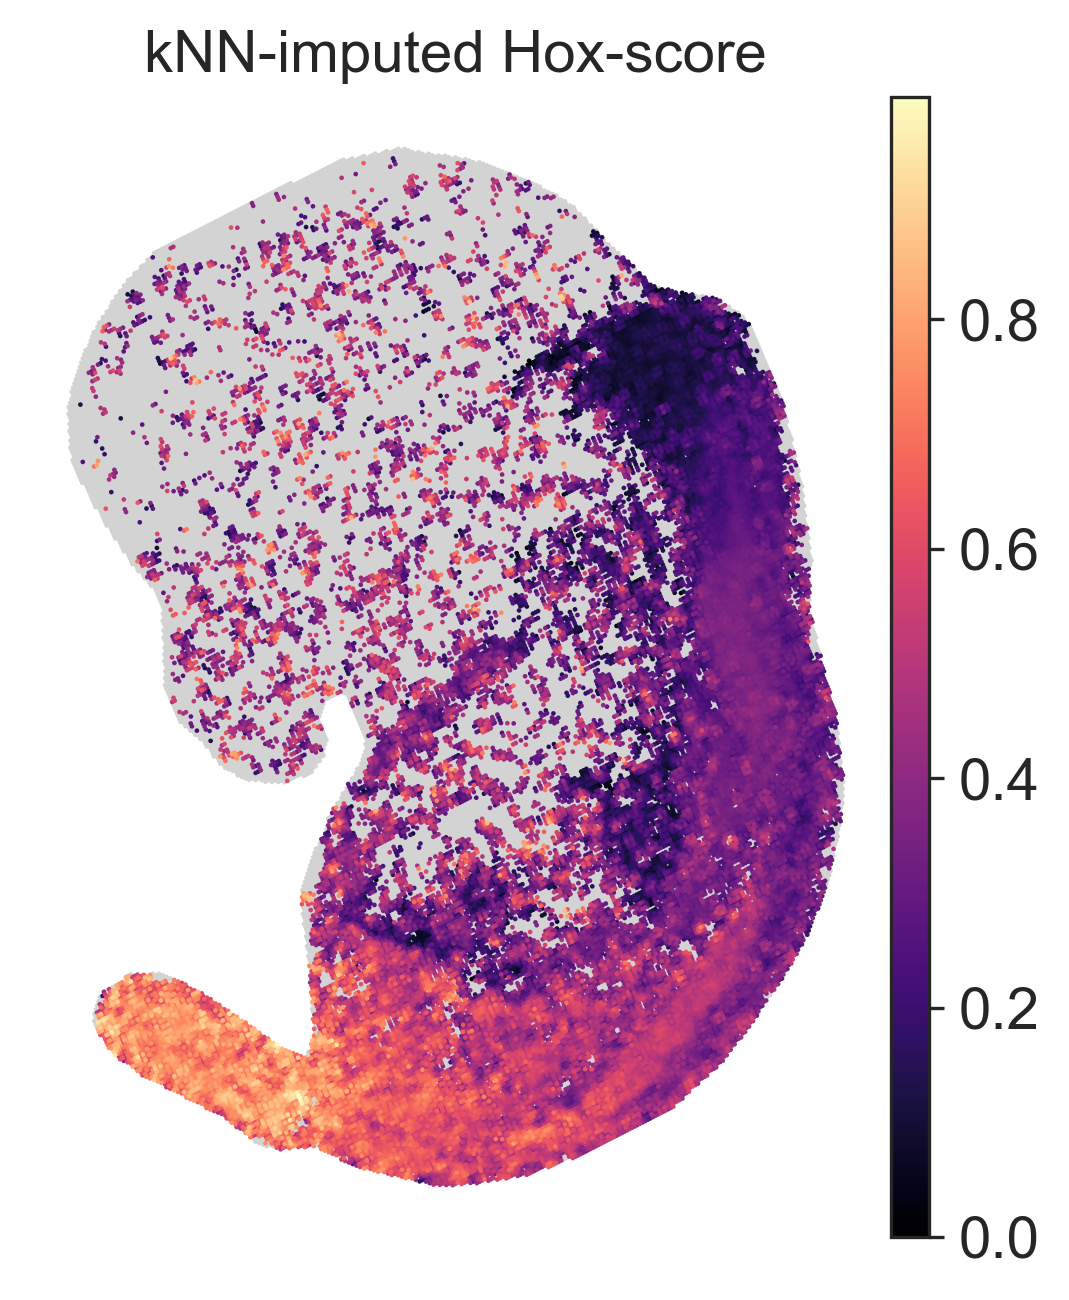

In [495]:
fig, ax = plt.subplots(figsize=(4, 5))

sc.pl.embedding(
    spatial,
    color="Hox_imputed",
    basis="spatial",
    s=5,
    ax=ax,
    show=False,
    frameon=False,
    title="kNN-imputed Hox-score",
    cmap="magma",
)